In [5]:
#All libraries import here
import torch
import torch.nn as nn
import torch.optim as optim
import requests
import json
import pandas as pd
import datetime as dt
import seaborn as sns
import time
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import ray
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from sklearn.model_selection import train_test_split
from functools import partial
import itertools
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
import time
import copy

In [6]:
# Ignore future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# Modelling for daily dataset using 8 features with lstm layer

## 1. Data loading

In [9]:
df = pd.read_csv('BTCUSDT_daily.csv')
df

,Date,Open,High,Low,Close,Volume
0,2018-01-01 11:00:00,13715.65,13818.55,12750.00,13380.00,8609.915844
1,2018-01-02 11:00:00,13382.16,15473.49,12890.02,14675.11,20078.092111
2,2018-01-03 11:00:00,14690.00,15307.56,14150.00,14919.51,15905.667639
3,2018-01-04 11:00:00,14919.51,15280.00,13918.04,15059.54,21329.649574
4,2018-01-05 11:00:00,15059.56,17176.24,14600.00,16960.39,23251.491125
...,...,...,...,...,...,...
2642,2025-03-27 11:00:00,86909.17,87756.39,85800.00,87232.01,17098.038970
2643,2025-03-28 11:00:00,87232.01,87515.67,83585.00,84424.38,27182.731690
2644,2025-03-29 11:00:00,84424.38,84624.73,81644.81,82648.54,11696.398640
2645,2025-03-30 11:00:00,82648.53,83534.64,81565.00,82389.99,9864.495080


In [11]:
# Make a copy of the DataFrame to avoid SettingWithCopyWarning
df_copy = df.copy()

# ---------- 1. Calculate Technical Indicators ----------

# Log Returns
df_copy['LogReturns'] = np.log(df_copy['Close'] / df_copy['Close'].shift(1))

# Parkinson Volatility
df_copy['Volatility'] = (np.log(df_copy['High']) - np.log(df_copy['Low'])) ** 2 / (4 * np.log(2))

# back 14-day SMA and EMA
df_copy['SMA_14'] = df_copy['Close'].rolling(window=14).mean()
# 14-day RSI
delta = df_copy['Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df_copy['RSI_14'] = 100 - (100 / (1 + rs))

# OBV
obv = [0]
for i in range(1, len(df_copy)):
    if df_copy['Close'].iloc[i] > df_copy['Close'].iloc[i - 1]:
        obv.append(obv[-1] + df_copy['Volume'].iloc[i])
    elif df_copy['Close'].iloc[i] < df_copy['Close'].iloc[i - 1]:
        obv.append(obv[-1] - df_copy['Volume'].iloc[i])
    else:
        obv.append(obv[-1])
df_copy['OBV'] = obv

# ATR (14-day)
high_low = df_copy['High'] - df_copy['Low']
high_close = np.abs(df_copy['High'] - df_copy['Close'].shift(1))
low_close = np.abs(df_copy['Low'] - df_copy['Close'].shift(1))
tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
df_copy['ATR_14'] = tr.rolling(window=14).mean()

# Drop rows with NaNs from rolling windows
df_copy = df_copy.dropna()

# ---------- 2. Normalize All 8 Features ----------
features_to_scale = ['LogReturns', 'Volume', 'Volatility', 'SMA_14', 'RSI_14', 'OBV', 'ATR_14']
scaler = MinMaxScaler(feature_range=(0, 1))

for feature in features_to_scale:
    df_copy.loc[:, f'{feature}_Norm'] = scaler.fit_transform(df_copy[feature].values.reshape(-1, 1)).flatten()

# ---------- 3. Create Sequences Using the Normalised Features ----------
def create_multifeature_sequences(data, feature_columns, seq_length=3):
    # Pre-allocate arrays
    n_samples = len(data) - seq_length
    n_features = len(feature_columns)
    X = np.zeros((n_samples, seq_length, n_features), dtype=np.float32)
    y = np.zeros(n_samples, dtype=np.float32)
    
    for i in range(n_samples):
        # Build the sequence for each sample
        for j in range(seq_length):
            X[i, j, :] = data.iloc[i + j][feature_columns].values
        # Target is the next raw LogReturns value
        y[i] = data.iloc[i + seq_length]['LogReturns']
    
    return X, y

# Use all 8 normalized features
feature_columns = ['LogReturns_Norm', 'Volume_Norm', 'Volatility_Norm'
                   ,'SMA_14_Norm'
                   #, 'EMA_14_Norm'
                   , 'RSI_14_Norm'
                   , 'OBV_Norm'
                   , 'ATR_14_Norm'
                  ]
X_all, y_all = create_multifeature_sequences(df_copy, feature_columns, seq_length=3)
df_copy

,Date,Open,High,Low,Close,Volume,LogReturns,Volatility,SMA_14,RSI_14,OBV,ATR_14,LogReturns_Norm,Volume_Norm,Volatility_Norm,SMA_14_Norm,RSI_14_Norm,OBV_Norm,ATR_14_Norm
14,2018-01-15 11:00:00,13477.98,14249.99,13147.79,13539.93,14652.094705,0.004808,0.002337,14803.407857,50.775896,55856.767179,1860.680000,0.745042,0.017583,0.018501,0.113630,0.484936,0.475056,0.294187
15,2018-01-16 11:00:00,13500.00,13542.93,9035.00,10900.00,63401.169175,-0.216880,0.059089,14533.757143,33.799160,-7544.401996,1998.141429,0.419535,0.081777,0.468509,0.110938,0.305204,0.468014,0.316867
16,2018-01-17 11:00:00,10899.99,11680.99,9037.94,10988.79,72331.796646,0.008113,0.023735,14252.991429,32.903015,64787.394650,2104.247857,0.749895,0.093537,0.188175,0.108135,0.295717,0.476048,0.334373
17,2018-01-18 11:00:00,10972.59,11878.82,10435.33,10961.97,48464.434937,-0.002444,0.006054,13960.307857,32.000018,16322.959713,2110.071429,0.734394,0.062108,0.047973,0.105212,0.286157,0.470665,0.335334
18,2018-01-19 11:00:00,10960.00,11795.00,10360.00,11474.98,34129.375421,0.045737,0.006069,13568.492857,22.557335,50452.335134,2028.554286,0.805138,0.043231,0.048095,0.101300,0.186188,0.474456,0.321884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2642,2025-03-27 11:00:00,86909.17,87756.39,85800.00,87232.01,17098.038970,0.003708,0.000183,85123.903571,65.745032,-814330.499400,2634.332857,0.743427,0.020804,0.001421,0.815742,0.643414,0.378403,0.421831
2643,2025-03-28 11:00:00,87232.01,87515.67,83585.00,84424.38,27182.731690,-0.032715,0.000762,85155.416429,51.139238,-841513.231090,2594.318571,0.689946,0.034083,0.006007,0.816056,0.488783,0.375384,0.415229
2644,2025-03-29 11:00:00,84424.38,84624.73,81644.81,82648.54,11696.398640,-0.021259,0.000464,85034.709286,45.934523,-853209.629730,2731.578571,0.706767,0.013691,0.003642,0.814851,0.433681,0.374084,0.437875
2645,2025-03-30 11:00:00,82648.53,83534.64,81565.00,82389.99,9864.495080,-0.003133,0.000205,85021.527857,49.521376,-863074.124810,2648.272857,0.733382,0.011278,0.001595,0.814720,0.471655,0.372989,0.424131


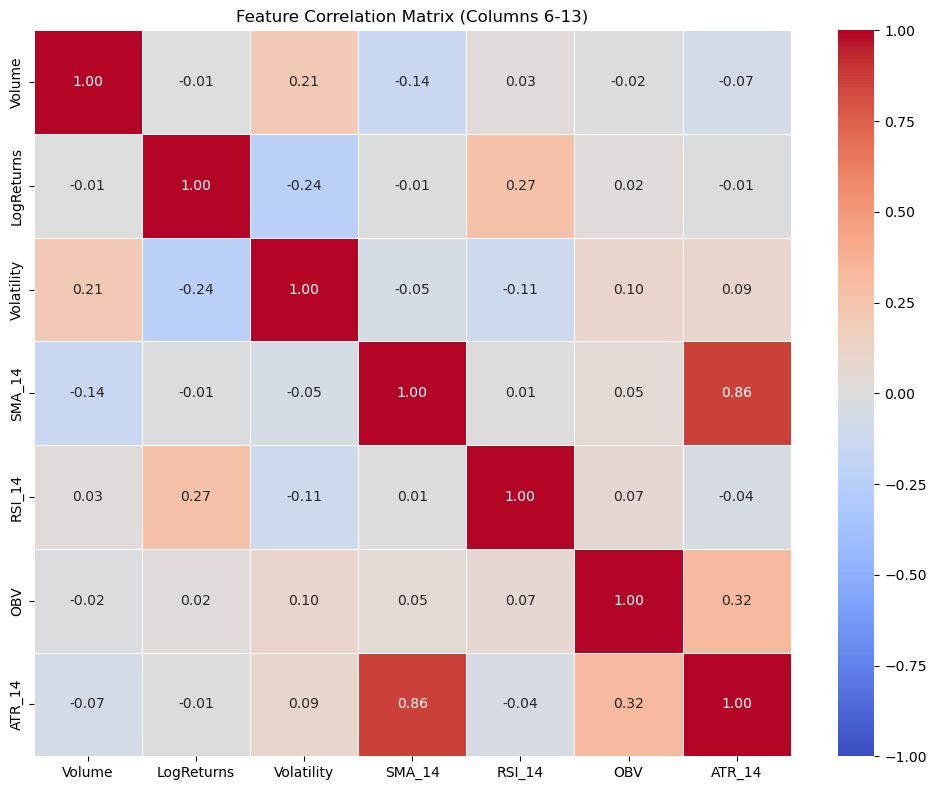

Selected columns: ['Volume', 'LogReturns', 'Volatility', 'SMA_14', 'RSI_14', 'OBV', 'ATR_14']


In [13]:
selected_columns = df_copy.iloc[:, 5:12]
correlation_matrix = selected_columns.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f', vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix (Columns 6-13)')
plt.tight_layout()
plt.show()

print("Selected columns:", list(selected_columns.columns))

## 2. Modelling

Starting Combined ν Grid Search for t-Distribution Model...
This will test three different sampling strategies.
COMBINED ν GRID SEARCH FOR T-DISTRIBUTION
Fixed Architecture: LSTM(32) -> Dense(32) -> Dense(32)
Learning Rate: 0.002, Dropout: 0.01

1. UNIFORM RANDOM SAMPLING
Testing 20 ν values: ['2.06', '2.75', '4.44', '6.47', '6.64', '7.27', '7.40', '8.99', '10.02', '10.19', '10.87', '13.00', '13.83', '15.85', '16.42', '16.42', '17.98', '18.43', '18.79', '19.36']
  ν = 2.057 (1/20)Early stopping at epoch 77
Test NLL: -1.9682
 -> NEW BEST! Val NLL: -2.0205
  ν = 2.751 (2/20)Epoch 100: Train NLL = -1.7078, Val NLL = -2.1359
Epoch 200: Train NLL = -1.7634, Val NLL = -2.1972
Epoch 300: Train NLL = -1.8138, Val NLL = -2.2561
Epoch 400: Train NLL = -1.8915, Val NLL = -2.3115
Epoch 500: Train NLL = -1.9491, Val NLL = -2.3597
Early stopping at epoch 528
Test NLL: -2.0039
 -> NEW BEST! Val NLL: -2.3437
  ν = 4.439 (3/20)Early stopping at epoch 74
Test NLL: -1.8661
 -> Val NLL: -1.9556
  ν = 6.47

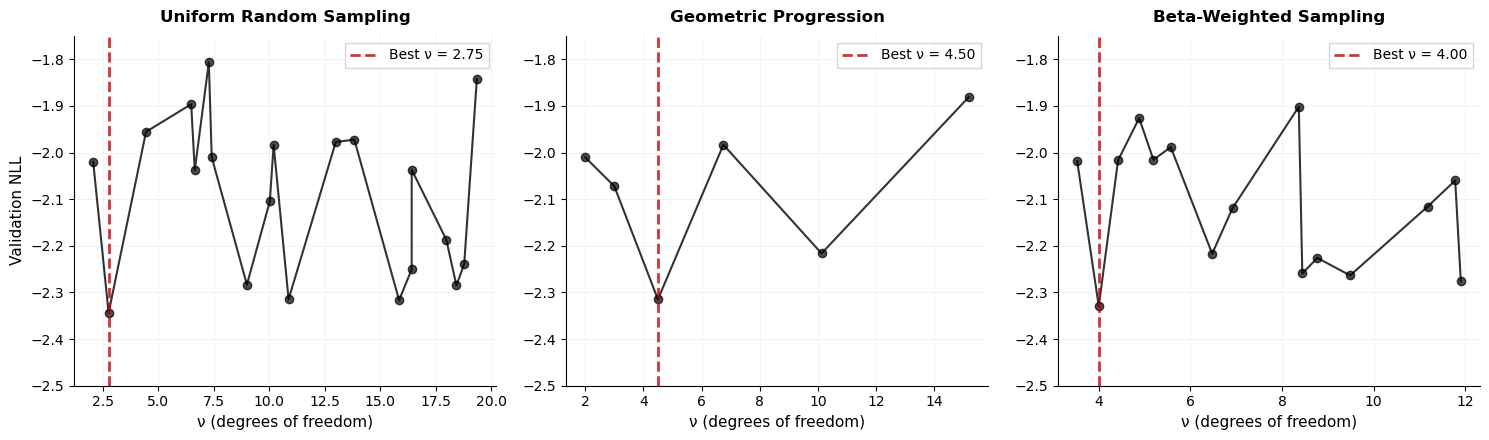


SUMMARY OF RESULTS

Comparison of Methods:
       Method Best ν Val NLL Test NLL Val σ̄ Test σ̄
      Uniform  2.751 -2.3437  -2.0039 0.0175  0.0192
    Geometric  4.500 -2.3149  -1.8083 0.0209  0.0246
Beta-Weighted  3.997 -2.3295  -2.0387 0.0200  0.0259


Top 5 ν Values from Best Method (Uniform):
 Rank      ν Val NLL Test NLL Val σ̄ Test σ̄
    1  2.751 -2.3437  -2.0039 0.0175  0.0192
    2 15.850 -2.3165  -0.1879 0.0242  0.0199
    3 10.867 -2.3146  -2.1683 0.0244  0.0266
    4 18.434 -2.2849  -2.1275 0.0265  0.0295
    5  8.988 -2.2833  -1.6679 0.0222  0.0210

RECOMMENDATION: Use ν = 2.751 (from Uniform method)


Grid search completed!
Outputs saved:
  - thesis_nu_grid_search_comparison.png
  - thesis_nu_search_summary.csv
  - thesis_nu_search_[method]_detailed.csv


In [133]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import time
import copy
from scipy.stats import beta

# -------------------------
# Combined ν Grid Search Methods
# -------------------------

def combined_nu_grid_search(X_train, y_train, X_val, y_val, X_test, y_test):
    """
    Combine three methods for ν search:
    1. Uniform random sampling
    2. Geometric progression
    3. Beta-weighted sampling
    """
    
    # Fixed configuration with 32-32-32 architecture
    fixed_config = {
        "lstm_hidden_dim": 32,
        "n_hidden1": 32,
        "n_hidden2": 32,
        "lr": 0.002,
        "dropout": 0.01,
        "activation": "relu"
    }
    
    print("="*70)
    print("COMBINED ν GRID SEARCH FOR T-DISTRIBUTION")
    print("="*70)
    print(f"Fixed Architecture: LSTM(32) -> Dense(32) -> Dense(32)")
    print(f"Learning Rate: {fixed_config['lr']}, Dropout: {fixed_config['dropout']}")
    print("="*70)
    
    results_all = {}
    
    # Method 1: Uniform Random Sampling
    print("\n1. UNIFORM RANDOM SAMPLING")
    np.random.seed(2025)
    nu_uniform = sorted(np.random.uniform(2.0, 20.0, 20).tolist())
    results_uniform, best_nu_uniform = _run_nu_search(
        X_train, y_train, X_val, y_val, X_test, y_test, 
        fixed_config, nu_uniform, "Uniform"
    )
    results_all['uniform'] = results_uniform
    
    # Method 2: Geometric Progression (1.5x)
    print("\n2. GEOMETRIC PROGRESSION (1.5x)")
    nu_geometric = []
    current_nu = 2.0
    while current_nu <= 20.0:
        nu_geometric.append(current_nu)
        current_nu *= 1.5
    results_geometric, best_nu_geometric = _run_nu_search(
        X_train, y_train, X_val, y_val, X_test, y_test, 
        fixed_config, nu_geometric, "Geometric"
    )
    results_all['geometric'] = results_geometric
    
    # Method 3: Beta-Weighted Sampling
    print("\n3. BETA-WEIGHTED SAMPLING (α=2, β=5)")
    np.random.seed(42)
    beta_samples = np.random.beta(2, 5, 15)
    nu_beta = sorted(2.0 + (20.0 - 2.0) * beta_samples)
    results_beta, best_nu_beta = _run_nu_search(
        X_train, y_train, X_val, y_val, X_test, y_test, 
        fixed_config, nu_beta, "Beta-Weighted"
    )
    results_all['beta'] = results_beta
    
    # Create professional visualization
    create_professional_plots(results_all)
    
    # Create results table
    create_results_table(results_all)
    
    return results_all

def _run_nu_search(X_train, y_train, X_val, y_val, X_test, y_test, fixed_config, nu_grid, method_name):
    """Core ν search function"""
    
    print(f"Testing {len(nu_grid)} ν values: {[f'{nu:.2f}' for nu in nu_grid]}")
    
    results = []
    best_val_loss = float('inf')
    best_nu = None
    
    for i, nu_value in enumerate(nu_grid):
        print(f"  ν = {nu_value:.3f} ({i+1}/{len(nu_grid)})", end='')
        
        try:
            # Train model
            model, train_losses, val_losses = train_fixed_t_model(
                X_train, y_train, X_val, y_val, X_test, y_test, 
                fixed_config, nu_fixed=nu_value
            )
            
            # Evaluate
            model.eval()
            with torch.no_grad():
                mu_val, sigma_val, nu_val = model(X_val)
                val_nll = t_distribution_nll_loss(y_val, mu_val, sigma_val, nu_val).item()
                
                mu_test, sigma_test, nu_test = model(X_test)
                test_nll = t_distribution_nll_loss(y_test, mu_test, sigma_test, nu_test).item()
            
            # Store results
            result = {
                'nu': nu_value,
                'val_nll': val_nll,
                'test_nll': test_nll,
                'mean_sigma_val': torch.mean(sigma_val).item(),
                'mean_sigma_test': torch.mean(sigma_test).item()
            }
            results.append(result)
            
            # Track best
            if val_nll < best_val_loss:
                best_val_loss = val_nll
                best_nu = nu_value
                print(f" -> NEW BEST! Val NLL: {val_nll:.4f}")
            else:
                print(f" -> Val NLL: {val_nll:.4f}")
            
        except Exception as e:
            print(f" -> FAILED: {str(e)}")
            results.append({
                'nu': nu_value, 
                'val_nll': float('inf'), 
                'test_nll': float('inf'),
                'mean_sigma_val': float('nan'), 
                'mean_sigma_test': float('nan')
            })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results).sort_values('val_nll').reset_index(drop=True)
    
    print(f"\n{method_name} Best ν: {best_nu:.3f}, Val NLL: {best_val_loss:.4f}")
    
    return results_df, best_nu

def create_professional_plots(results_all):
    """Create three professional plots in a single row"""
    
    # Set up the figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))
    
    # Color scheme: black for data points, red for best value
    data_color = '#000000'  # Black
    best_color = '#CC0000'  # Red
    
    # Plot settings
    methods = ['uniform', 'geometric', 'beta']
    titles = ['Uniform Random Sampling', 'Geometric Progression', 'Beta-Weighted Sampling']
    
    for idx, (method, title) in enumerate(zip(methods, titles)):
        ax = axes[idx]
        df = results_all[method]
        
        # Filter valid results
        valid_df = df[df['val_nll'] != float('inf')].copy()
        if len(valid_df) == 0:
            continue
            
        best_nu = valid_df.iloc[0]['nu']
        
        # Plot data points
        ax.plot(valid_df['nu'], valid_df['val_nll'], 'o', 
                color=data_color, markersize=6, alpha=0.7)
        
        # Fit and plot smooth curve
        sorted_df = valid_df.sort_values('nu')
        ax.plot(sorted_df['nu'], sorted_df['val_nll'], '-', 
                color=data_color, linewidth=1.5, alpha=0.8)
        
        # Mark best value
        best_point = valid_df[valid_df['nu'] == best_nu].iloc[0]
        ax.axvline(x=best_nu, color=best_color, linestyle='--', 
                  linewidth=2, alpha=0.8, label=f'Best ν = {best_nu:.2f}')
        
        # Formatting
        ax.set_xlabel('ν (degrees of freedom)', fontsize=11)
        if idx == 0:
            ax.set_ylabel('Validation NLL', fontsize=11)
        ax.set_title(title, fontsize=12, fontweight='bold', pad=10)
        ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
        ax.legend(loc='upper right', fontsize=10, frameon=True, fancybox=False)
        
        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Set x-axis limits with padding
        x_min, x_max = valid_df['nu'].min(), valid_df['nu'].max()
        x_range = x_max - x_min
        ax.set_xlim(x_min - 0.05*x_range, x_max + 0.05*x_range)
        ax.set_ylim(-2.5, -1.75) 
    
    plt.tight_layout()
    plt.savefig('thesis_nu_grid_search_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

def create_results_table(results_all):
    """Create a comprehensive results table"""
    
    # Collect best results from each method
    summary_data = []
    
    for method_name, method_key in [('Uniform', 'uniform'), 
                                     ('Geometric', 'geometric'), 
                                     ('Beta-Weighted', 'beta')]:
        df = results_all[method_key]
        valid_df = df[df['val_nll'] != float('inf')]
        
        if len(valid_df) > 0:
            best_row = valid_df.iloc[0]
            summary_data.append({
                'Method': method_name,
                'Best ν': f"{best_row['nu']:.3f}",
                'Val NLL': f"{best_row['val_nll']:.4f}",
                'Test NLL': f"{best_row['test_nll']:.4f}",
                'Val σ̄': f"{best_row['mean_sigma_val']:.4f}",
                'Test σ̄': f"{best_row['mean_sigma_test']:.4f}"
            })
    
    summary_df = pd.DataFrame(summary_data)
    
    # Create detailed table for best method
    best_method = summary_df.loc[summary_df['Val NLL'].astype(float).idxmin(), 'Method']
    best_method_key = {'Uniform': 'uniform', 'Geometric': 'geometric', 'Beta-Weighted': 'beta'}[best_method]
    
    print("\n" + "="*70)
    print("SUMMARY OF RESULTS")
    print("="*70)
    print("\nComparison of Methods:")
    print(summary_df.to_string(index=False))
    
    # Show top 5 results from best method
    print(f"\n\nTop 5 ν Values from Best Method ({best_method}):")
    best_df = results_all[best_method_key]
    valid_best = best_df[best_df['val_nll'] != float('inf')].head(5)
    
    top5_df = pd.DataFrame({
        'Rank': range(1, len(valid_best) + 1),
        'ν': [f"{x:.3f}" for x in valid_best['nu']],
        'Val NLL': [f"{x:.4f}" for x in valid_best['val_nll']],
        'Test NLL': [f"{x:.4f}" for x in valid_best['test_nll']],
        'Val σ̄': [f"{x:.4f}" for x in valid_best['mean_sigma_val']],
        'Test σ̄': [f"{x:.4f}" for x in valid_best['mean_sigma_test']]
    })
    
    print(top5_df.to_string(index=False))
    
    # Final recommendation
    overall_best = summary_df.loc[summary_df['Val NLL'].astype(float).idxmin()]
    print("\n" + "="*70)
    print(f"RECOMMENDATION: Use ν = {overall_best['Best ν']} (from {overall_best['Method']} method)")
    print("="*70)
    
    # Save comprehensive results
    summary_df.to_csv('thesis_nu_search_summary.csv', index=False)
    for method, df in results_all.items():
        df.to_csv(f'thesis_nu_search_{method}_detailed.csv', index=False)
    
    return summary_df

# Main execution function
def run_combined_nu_search():
    """Execute the combined ν grid search"""
    
    print("Starting Combined ν Grid Search for t-Distribution Model...")
    print("This will test three different sampling strategies.")
    
    results = combined_nu_grid_search(
        X_train, y_train, X_val, y_val, X_test, y_test
    )
    
    print("\n\nGrid search completed!")
    print("Outputs saved:")
    print("  - thesis_nu_grid_search_comparison.png")
    print("  - thesis_nu_search_summary.csv")
    print("  - thesis_nu_search_[method]_detailed.csv")
    
    return results

# Usage:
results = run_combined_nu_search()

Using fixed ν = 2.751
Epoch 100: Train NLL = -1.9328, Val NLL = -2.3069
Early stopping at epoch 190
Test NLL: -2.1810


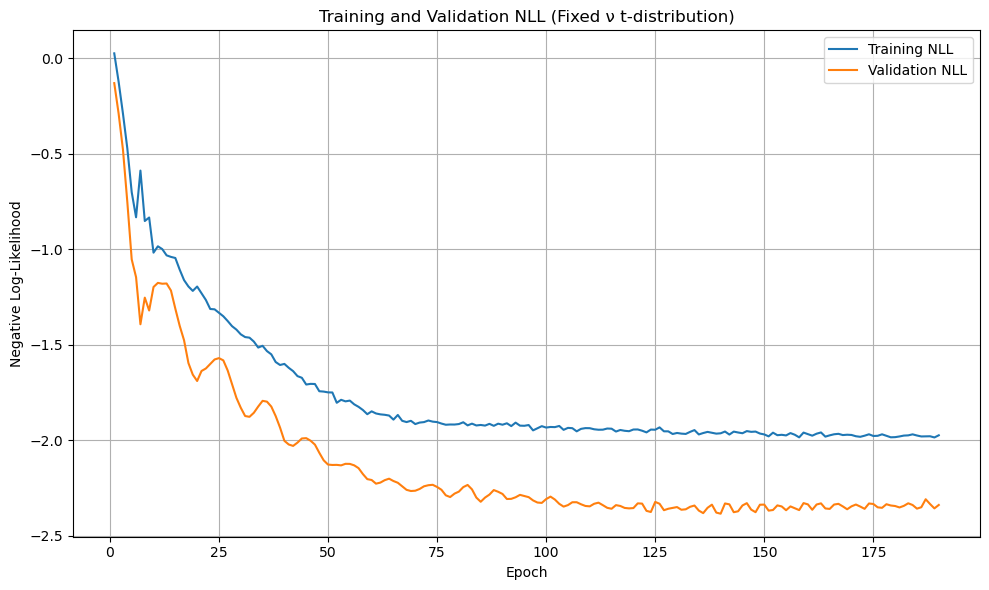

In [225]:
# -------------------------
# 0. Set Seeds for Reproducibility
# -------------------------
def set_all_seeds(seed=2025):
    """Set all random seeds for reproducibility"""
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    import os
    os.environ['PYTHONHASHSEED'] = str(seed)

# Set the seed at the beginning
set_all_seeds(2025)

nu_fixed_value = 2.75  # use your fitted value from R/Python
# -------------------------
# 1. Model architecture with fixed ν
# -------------------------
class FixedTDensityNetworkWithLSTM(nn.Module):
    def __init__(self, input_dim=3, seq_length=3, lstm_hidden_dim=16, 
                 n_hidden1=32, n_hidden2=32, dropout=0.1, activation="relu", nu_fixed=2.75):
        super().__init__()
        
        self.nu_fixed = torch.tensor(nu_fixed, dtype=torch.float32)
        self.input_dim = input_dim        
        self.seq_length = seq_length     
        self.lstm_hidden_dim = lstm_hidden_dim  

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=lstm_hidden_dim,
            batch_first=True,
            bidirectional=False
        )
        
        # First hidden layer
        layers_h1 = [nn.Linear(lstm_hidden_dim, n_hidden1)]
        layers_h1.append(getattr(nn, activation.capitalize())() if hasattr(nn, activation.capitalize()) else nn.ReLU())
        if dropout > 0:
            layers_h1.append(nn.Dropout(dropout))
        self.hidden_layer1 = nn.Sequential(*layers_h1)

        # Second hidden layer
        layers_h2 = [nn.Linear(n_hidden1, n_hidden2)]
        layers_h2.append(getattr(nn, activation.capitalize())() if hasattr(nn, activation.capitalize()) else nn.ReLU())
        if dropout > 0:
            layers_h2.append(nn.Dropout(dropout))
        self.hidden_layer2 = nn.Sequential(*layers_h2)
        
        # Output layers
        self.mu_layer = nn.Linear(n_hidden2, 1)
        self.sigma_layer = nn.Linear(n_hidden2, 1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(1, batch_size, self.lstm_hidden_dim).to(x.device)
        c0 = torch.zeros(1, batch_size, self.lstm_hidden_dim).to(x.device)
        lstm_out, _ = self.lstm(x, (h0, c0))
        lstm_final = lstm_out[:, -1, :]
        hidden_output1 = self.hidden_layer1(lstm_final)
        hidden_output2 = self.hidden_layer2(hidden_output1)
        mu = self.mu_layer(hidden_output2)
        sigma = torch.exp(self.sigma_layer(hidden_output2))  # ensures positivity
        nu = torch.full_like(mu, self.nu_fixed)
        return mu, sigma, nu

# -------------------------
# 2. t-distribution NLL loss
# -------------------------
def t_distribution_nll_loss(y, mu, sigma, nu):
    error = (y - mu) / sigma
    log_likelihood = (
        torch.lgamma((nu + 1) / 2)
        - torch.lgamma(nu / 2)
        - 0.5 * torch.log(nu * np.pi)
        - torch.log(sigma)
        - ((nu + 1) / 2) * torch.log(1 + (error ** 2) / nu)
    )
    return -log_likelihood.mean()

# -------------------------
# 3. Weight initialization
# -------------------------
def init_weights(model):
    for name, param in model.named_parameters():
        if 'weight' in name:
            if param.dim() >= 2:
                nn.init.xavier_normal_(param)
            else:
                nn.init.ones_(param)
        elif 'bias' in name:
            nn.init.zeros_(param)
            if 'sigma_layer.bias' in name:
                nn.init.constant_(param, -1.0)

# -------------------------
# 4. Training function
# -------------------------
def train_fixed_t_model(X_train, y_train, X_val, y_val, X_test, y_test, config, nu_fixed=2.):
    model = FixedTDensityNetworkWithLSTM(
        input_dim=X_train.shape[2],
        seq_length=X_train.shape[1],
        lstm_hidden_dim=config["lstm_hidden_dim"],
        n_hidden1=config["n_hidden1"],
        n_hidden2=config["n_hidden2"],
        dropout=config["dropout"],
        activation=config["activation"],
        nu_fixed=nu_fixed
    )
    init_weights(model)
    
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])
    
    num_epochs = 2000
    train_losses = []
    val_losses = []
    patience = 50
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        mu, sigma, nu = model(X_train)
        loss_train = t_distribution_nll_loss(y_train, mu, sigma, nu)
        loss_train.backward()
        optimizer.step()
        train_losses.append(loss_train.item())
        
        model.eval()
        with torch.no_grad():
            mu_val, sigma_val, nu_val = model(X_val)
            loss_val = t_distribution_nll_loss(y_val, mu_val, sigma_val, nu_val)
            val_losses.append(loss_val.item())
        
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}: Train NLL = {loss_train.item():.4f}, Val NLL = {loss_val.item():.4f}")
        
        if loss_val < best_val_loss:
            best_val_loss = loss_val
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
                
    model.load_state_dict(best_model_state)
    model.eval()
    with torch.no_grad():
        mu_test, sigma_test, nu_test = model(X_test)
        test_loss = t_distribution_nll_loss(y_test, mu_test, sigma_test, nu_test)
    print(f"Test NLL: {test_loss.item():.4f}")
    
    return model, train_losses, val_losses

# -------------------------
# 5. Data Preparation (assuming X_all, y_all exist)
# -------------------------

train_size = int(len(X_all) * 0.7)
val_size = int(len(X_all) * 0.15)
test_size = len(X_all) - train_size - val_size

X_train_np = X_all[:train_size]
y_train_np = y_all[:train_size]
X_val_np = X_all[train_size:train_size+val_size]
y_val_np = y_all[train_size:train_size+val_size]
X_test_np = X_all[train_size+val_size:]
y_test_np = y_all[train_size+val_size:]

X_train = torch.FloatTensor(X_train_np)
y_train = torch.FloatTensor(y_train_np).unsqueeze(1)
X_val = torch.FloatTensor(X_val_np)
y_val = torch.FloatTensor(y_val_np).unsqueeze(1)
X_test = torch.FloatTensor(X_test_np)
y_test = torch.FloatTensor(y_test_np).unsqueeze(1)

# -------------------------
# 6. Run the model
# -------------------------
manual_config = {
    "lstm_hidden_dim": 64,
    "n_hidden1": 64,
    "n_hidden2": 64,
    "lr": 0.005,
    "dropout": 0.1,
    "activation": "elu"
}
print("Using fixed ν =", 2.751) 

model, train_losses, val_losses = train_fixed_t_model(X_train, y_train, X_val, y_val, X_test, y_test, manual_config, nu_fixed=2.75)
 
# -------------------------
# 7. Plot losses
# -------------------------
plt.figure(figsize=(10, 6))
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, label='Training NLL')
plt.plot(epochs, val_losses, label='Validation NLL')
plt.xlabel('Epoch')
plt.ylabel('Negative Log-Likelihood')
plt.title('Training and Validation NLL (Fixed ν t-distribution)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Total rows in df_copy: 2633
Total sequences created: 2630
Expected sequences: 2630 = 2630

Data date range: 2018-01-18 11:00:00 to 2025-03-31 11:00:00
Train: 1840 samples (2018-01-18 11:00:00 to 2023-01-31 11:00:00)
Val: 394 samples (2023-02-01 11:00:00 to 2024-02-29 11:00:00)
Test: 396 samples (2024-03-01 11:00:00 to 2025-03-31 11:00:00)


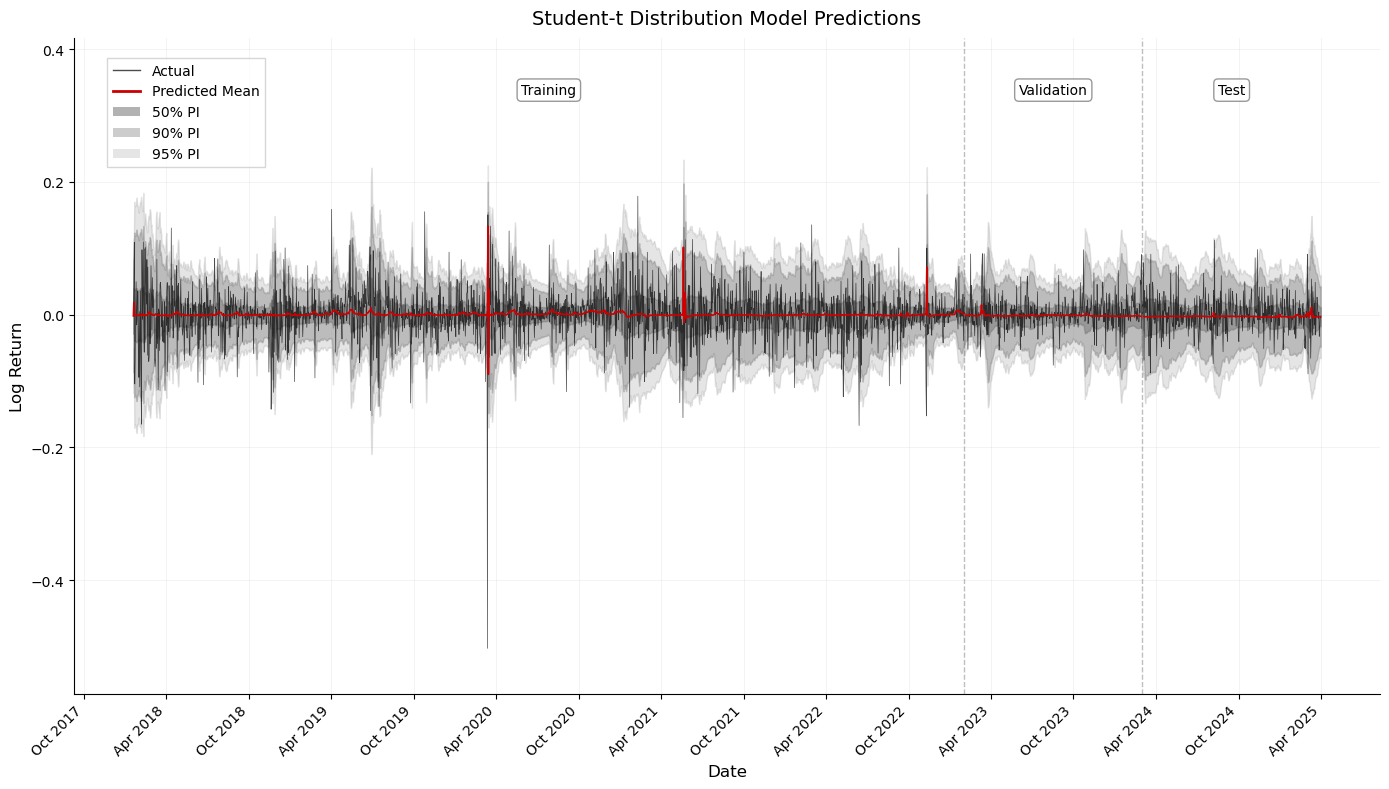

Full timeline plot saved as 'thesis_t_distribution_timeline.png'


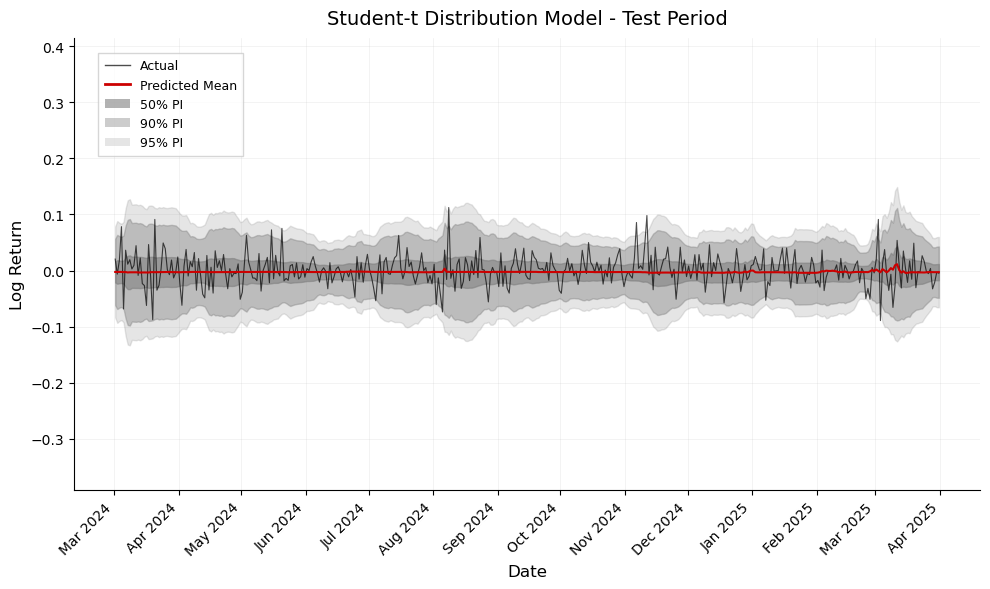

Test period plot saved as 'thesis_t_distribution_testline.png'


In [227]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from scipy.stats import t
import torch

# -----------------------------------------------
# 1. Get predictions from the trained model
# -----------------------------------------------
model.eval()
with torch.no_grad():
    train_mu, train_sigma, _ = model(X_train)
    val_mu, val_sigma, _ = model(X_val)
    test_mu, test_sigma, _ = model(X_test)

# Move to CPU and convert to NumPy
train_mu = train_mu.cpu().numpy()
train_sigma = train_sigma.cpu().numpy()
val_mu = val_mu.cpu().numpy()
val_sigma = val_sigma.cpu().numpy()
test_mu = test_mu.cpu().numpy()
test_sigma = test_sigma.cpu().numpy()

y_train_np = y_train.cpu().numpy()
y_val_np = y_val.cpu().numpy()
y_test_np = y_test.cpu().numpy()

# -----------------------------------------------
# 2. Define t-distribution quantile multipliers
# -----------------------------------------------
nu = 2.75  # fixed ν
def t_quantile_multiplier(df, confidence_level):
    alpha = 1 - confidence_level
    return t.ppf(1 - alpha / 2, df)

multiplier_95 = t_quantile_multiplier(nu, 0.95)
multiplier_90 = t_quantile_multiplier(nu, 0.90)
multiplier_50 = t_quantile_multiplier(nu, 0.50)

# -----------------------------------------------
# 3. Get date indices from your data
# -----------------------------------------------
# Since you created sequences, we need to get the dates from df_copy after processing

# Get the dates from the Date column in df_copy
# The dates correspond to the END of each sequence (the prediction target time)
# Since seq_length=3, the first prediction corresponds to index 3 in df_copy

seq_length = 3  # Your sequence length
available_dates = df_copy['Date'].iloc[seq_length:].values

# Make sure we have the right number of dates
print(f"Total rows in df_copy: {len(df_copy)}")
print(f"Total sequences created: {len(y_all)}")
print(f"Expected sequences: {len(df_copy) - seq_length} = {len(df_copy) - seq_length}")
assert len(available_dates) == len(y_all), f"Date mismatch: {len(available_dates)} dates vs {len(y_all)} samples"

# Now split the dates according to your train/val/test split
train_size = len(train_mu)
val_size = len(val_mu)
test_size = len(test_mu)

# Get the date arrays for each split
train_dates = available_dates[:train_size]
val_dates = available_dates[train_size:train_size + val_size]
test_dates = available_dates[train_size + val_size:train_size + val_size + test_size]

# Convert to pandas datetime if they aren't already
train_dates = pd.to_datetime(train_dates)
val_dates = pd.to_datetime(val_dates)
test_dates = pd.to_datetime(test_dates)

print(f"\nData date range: {train_dates[0]} to {test_dates[-1]}")
print(f"Train: {len(train_dates)} samples ({train_dates[0]} to {train_dates[-1]})")
print(f"Val: {len(val_dates)} samples ({val_dates[0]} to {val_dates[-1]})")
print(f"Test: {len(test_dates)} samples ({test_dates[0]} to {test_dates[-1]})")

# -----------------------------------------------
# 4. Plot 1: Full timeline predictions and prediction intervals
# -----------------------------------------------
fig, ax = plt.subplots(figsize=(14, 8))

# Define colors - using grayscale for PIs and red for predictions
actual_color = '#000000'  # Pure black for actual data
pred_color = '#CC0000'    # Red for predicted mean
pi_color = '#808080'      # Gray for prediction intervals

# Extend y-axis limits to make room for legend
y_min = min(y_train_np.min(), y_val_np.min(), y_test_np.min())
y_max = max(y_train_np.max(), y_val_np.max(), y_test_np.max())
y_range = y_max - y_min
ax.set_ylim(y_min - 0.1*y_range, y_max + 0.35*y_range)  # Extended upper limit for legend

# ---------- Train ----------
ax.plot(train_dates, y_train_np, color=actual_color, alpha=0.7, linewidth=0.5, label='Actual')
ax.plot(train_dates, train_mu, color=pred_color, linewidth=1.2, label='Predicted Mean')
ax.fill_between(train_dates, train_mu.flatten() - multiplier_95 * train_sigma.flatten(),
                train_mu.flatten() + multiplier_95 * train_sigma.flatten(), color=pi_color, alpha=0.2)
ax.fill_between(train_dates, train_mu.flatten() - multiplier_90 * train_sigma.flatten(),
                train_mu.flatten() + multiplier_90 * train_sigma.flatten(), color=pi_color, alpha=0.4)
ax.fill_between(train_dates, train_mu.flatten() - multiplier_50 * train_sigma.flatten(),
                train_mu.flatten() + multiplier_50 * train_sigma.flatten(), color=pi_color, alpha=0.6)

# ---------- Validation ----------
ax.plot(val_dates, y_val_np, color=actual_color, alpha=0.7, linewidth=0.5)
ax.plot(val_dates, val_mu, color=pred_color, linewidth=1.2)
ax.fill_between(val_dates, val_mu.flatten() - multiplier_95 * val_sigma.flatten(),
                val_mu.flatten() + multiplier_95 * val_sigma.flatten(), color=pi_color, alpha=0.2)
ax.fill_between(val_dates, val_mu.flatten() - multiplier_90 * val_sigma.flatten(),
                val_mu.flatten() + multiplier_90 * val_sigma.flatten(), color=pi_color, alpha=0.4)
ax.fill_between(val_dates, val_mu.flatten() - multiplier_50 * val_sigma.flatten(),
                val_mu.flatten() + multiplier_50 * val_sigma.flatten(), color=pi_color, alpha=0.6)

# ---------- Test ----------
ax.plot(test_dates, y_test_np, color=actual_color, alpha=0.7, linewidth=0.5)
ax.plot(test_dates, test_mu, color=pred_color, linewidth=1.2)
ax.fill_between(test_dates, test_mu.flatten() - multiplier_95 * test_sigma.flatten(),
                test_mu.flatten() + multiplier_95 * test_sigma.flatten(), color=pi_color, alpha=0.2)
ax.fill_between(test_dates, test_mu.flatten() - multiplier_90 * test_sigma.flatten(),
                test_mu.flatten() + multiplier_90 * test_sigma.flatten(), color=pi_color, alpha=0.4)
ax.fill_between(test_dates, test_mu.flatten() - multiplier_50 * test_sigma.flatten(),
                test_mu.flatten() + multiplier_50 * test_sigma.flatten(), color=pi_color, alpha=0.6)

# ---------- Add vertical lines at split points ----------
ax.axvline(x=train_dates[-1], color='gray', linestyle='--', alpha=0.5, linewidth=1)
ax.axvline(x=val_dates[-1], color='gray', linestyle='--', alpha=0.5, linewidth=1)

# ---------- Add period labels ----------
# Calculate positions for period labels
train_mid = train_dates[len(train_dates)//2]
val_mid = val_dates[len(val_dates)//2]
test_mid = test_dates[len(test_dates)//2]

# Add text labels for each period
y_position = y_max + 0.25*y_range  # Position labels higher
ax.text(train_mid, y_position, 'Training', ha='center', va='top', fontsize=10, 
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))
ax.text(val_mid, y_position, 'Validation', ha='center', va='top', fontsize=10,
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))
ax.text(test_mid, y_position, 'Test', ha='center', va='top', fontsize=10,
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))

# ---------- Format x-axis with abbreviated month format ----------
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Jan 2023 format
plt.xticks(rotation=45, ha='right')

# Set appropriate date locator based on your data range
date_range_days = (test_dates[-1] - train_dates[0]).days
if date_range_days > 365 * 2:  # More than 2 years
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Every 6 months
elif date_range_days > 365:  # More than 1 year
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Every 3 months
else:
    ax.xaxis.set_major_locator(mdates.MonthLocator())  # Every month

# ---------- Create custom legend ----------
# Create legend elements manually for cleaner appearance
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], color=actual_color, lw=1, alpha=0.7, label='Actual'),
    Line2D([0], [0], color=pred_color, lw=2, label='Predicted Mean'),
    Patch(facecolor=pi_color, alpha=0.6, label='50% PI'),
    Patch(facecolor=pi_color, alpha=0.4, label='90% PI'),
    Patch(facecolor=pi_color, alpha=0.2, label='95% PI')
]

# Place legend inside the plot at upper left
ax.legend(handles=legend_elements, loc='upper left', 
          frameon=True, fancybox=False, shadow=False, ncol=1, fontsize=10,
          bbox_to_anchor=(0.02, 0.98))

# ---------- Final formatting ----------
ax.set_title(f'Student-t Distribution Model Predictions', fontsize=14, pad=10)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Log Return', fontsize=12)
ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)  # Grid lines behind data

# Remove top and right spines for cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.tight_layout()
plt.savefig('thesis_t_distribution_timeline.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()  # Close the figure to save memory

print("Full timeline plot saved as 'thesis_t_distribution_timeline.png'")

# -----------------------------------------------
# 5. Plot 2: Zoomed-in plot for test period
# -----------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

# Extend y-axis for test period
y_min_test = y_test_np.min()
y_max_test = y_test_np.max()
y_range_test = y_max_test - y_min_test
ax.set_ylim(y_min_test - 1.5*y_range_test, y_max_test + 1.5*y_range_test)

# Plot with same color scheme
ax.plot(test_dates, y_test_np, color=actual_color, alpha=0.7, linewidth=0.8, label='Actual')
ax.plot(test_dates, test_mu, color=pred_color, linewidth=1.5, label='Predicted Mean')
ax.fill_between(test_dates, test_mu.flatten() - multiplier_95 * test_sigma.flatten(),
                test_mu.flatten() + multiplier_95 * test_sigma.flatten(), 
                color=pi_color, alpha=0.2, label='95% PI')
ax.fill_between(test_dates, test_mu.flatten() - multiplier_90 * test_sigma.flatten(),
                test_mu.flatten() + multiplier_90 * test_sigma.flatten(), 
                color=pi_color, alpha=0.4, label='90% PI')
ax.fill_between(test_dates, test_mu.flatten() - multiplier_50 * test_sigma.flatten(),
                test_mu.flatten() + multiplier_50 * test_sigma.flatten(), 
                color=pi_color, alpha=0.6, label='50% PI')

# Format x-axis with abbreviated month format and reduced number of dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Jan 2023 format
plt.xticks(rotation=45, ha='right')

# UPDATED: Reduce the number of date labels for test period
test_range_days = (test_dates[-1] - test_dates[0]).days

if test_range_days > 180:  # More than 6 months
    ax.xaxis.set_major_locator(mdates.MonthLocator())  # Monthly
elif test_range_days > 60:  # More than 2 months
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))  # Every 3 weeks
elif test_range_days > 30:  # More than 1 month
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))  # Every 2 weeks
elif test_range_days > 14:  # More than 2 weeks
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))  # Every 5 days
else:
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))  # Every 3 days

# Legend inside with spacing parameters
legend_elements = [
    Line2D([0], [0], color=actual_color, lw=1, alpha=0.7, label='Actual'),
    Line2D([0], [0], color=pred_color, lw=2, label='Predicted Mean'),
    Patch(facecolor=pi_color, alpha=0.6, label='50% PI'),
    Patch(facecolor=pi_color, alpha=0.4, label='90% PI'),
    Patch(facecolor=pi_color, alpha=0.2, label='95% PI')
]

ax.legend(handles=legend_elements, loc='upper left',
          frameon=True, fancybox=False, shadow=False, ncol=1,
          bbox_to_anchor=(0.02, 0.98),
          prop={'size': 9},           # Alternative font size control
          borderpad=0.5,              # Whitespace inside legend border
          columnspacing=1.0,          # Space between columns (if ncol>1)
          handlelength=2.0,           # Length of legend handles
          handletextpad=0.8,          # Space between handle and text
          labelspacing=0.5)           # Vertical space between entries

ax.set_title(f'Student-t Distribution Model - Test Period', fontsize=14, pad=10)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Log Return', fontsize=12)
ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.tight_layout()
plt.savefig('thesis_t_distribution_testline.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()  # Close the figure to save memory

print("Test period plot saved as 'thesis_t_distribution_testline.png'")

Initial price: $10,988.79
Using Student-t distribution with ν = 2.75


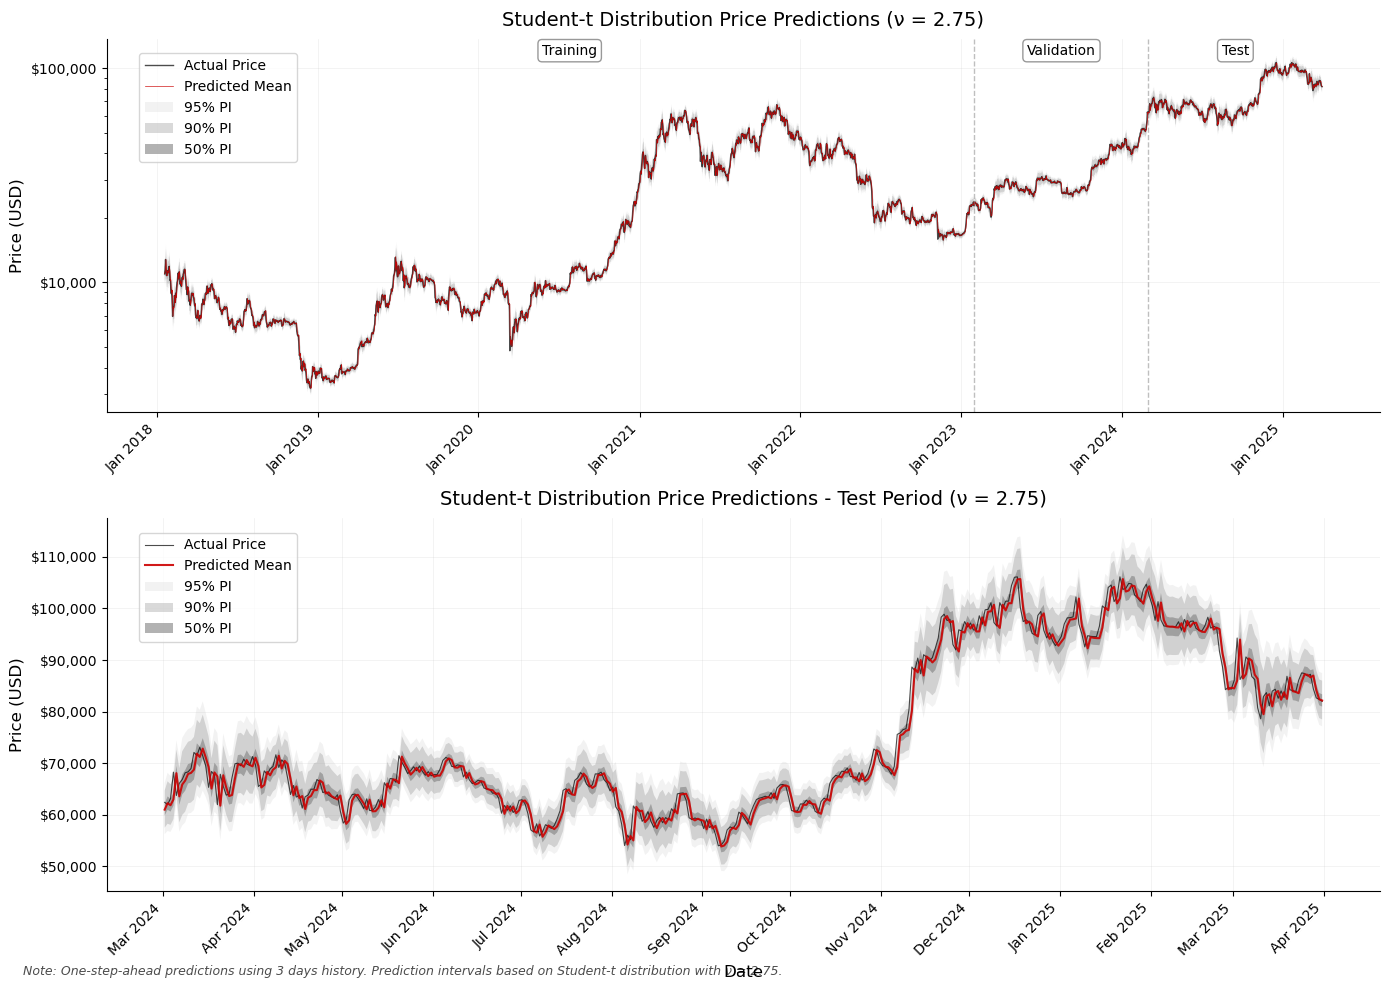

Plots saved as:
  - thesis_t_distribution_price_timeline.png
  - thesis_t_distribution_price_testline.png

Price Statistics:
Final actual price: $82,002.02
Final predicted mean price: $82,153.73
Final 95% PI: $77,157.61 - $87,473.37

Test Period Metrics (Log Returns):
RMSE: 0.027573
MAE: 0.020149
Mean σ: 0.024720

95% interval multipliers:
  Student-t (ν=2.75): 3.353
  Gaussian: 1.960
  Ratio (t/Gaussian): 1.710x wider


In [217]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import torch
from scipy.stats import t
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

def plot_tdistribution_price_predictions(model, X_train, X_val, X_test, 
                                        y_train, y_val, y_test,
                                        df_copy, seq_length=3,
                                        confidence_levels=[0.5, 0.9, 0.95],
                                        nu_fixed=2.75,  # Your fixed degrees of freedom
                                        save_path='thesis_tdistribution_price_predictions.png'):
    """
    Convert Student-t distribution network log return predictions to price predictions.
    Shows one-step-ahead predictions converted to prices.
    """
    
    # Get model predictions
    model.eval()
    with torch.no_grad():
        train_mu, train_sigma, _ = model(X_train)
        val_mu, val_sigma, _ = model(X_val)
        test_mu, test_sigma, _ = model(X_test)
    
    # Convert to numpy
    train_mu = train_mu.cpu().numpy().flatten()
    train_sigma = train_sigma.cpu().numpy().flatten()
    val_mu = val_mu.cpu().numpy().flatten()
    val_sigma = val_sigma.cpu().numpy().flatten()
    test_mu = test_mu.cpu().numpy().flatten()
    test_sigma = test_sigma.cpu().numpy().flatten()
    
    # Combine all predictions
    all_mu = np.concatenate([train_mu, val_mu, test_mu])
    all_sigma = np.concatenate([train_sigma, val_sigma, test_sigma])
    
    # Combine all actual values
    y_train_np = y_train.cpu().numpy().flatten()
    y_val_np = y_val.cpu().numpy().flatten()
    y_test_np = y_test.cpu().numpy().flatten()
    y_all = np.concatenate([y_train_np, y_val_np, y_test_np])
    
    # Get dates
    available_dates = df_copy['Date'].iloc[seq_length:seq_length+len(y_all)].values
    available_dates = pd.to_datetime(available_dates)
    
    # Split dates
    train_size = len(train_mu)
    val_size = len(val_mu)
    test_size = len(test_mu)
    
    train_dates = available_dates[:train_size]
    val_dates = available_dates[train_size:train_size+val_size]
    test_dates = available_dates[train_size+val_size:]
    
    # Get initial price
    if 'Close' in df_copy.columns:
        initial_price = df_copy['Close'].iloc[seq_length-1]
    else:
        initial_price = 50000  # Default Bitcoin price if not available
    
    print(f"Initial price: ${initial_price:,.2f}")
    print(f"Using Student-t distribution with ν = {nu_fixed}")
    
    # Convert actual log returns to prices
    actual_prices = np.zeros(len(y_all))
    actual_prices[0] = initial_price * np.exp(y_all[0])
    for i in range(1, len(y_all)):
        actual_prices[i] = actual_prices[i-1] * np.exp(y_all[i])
    
    # Calculate price predictions for different confidence levels
    price_bands = {}
    
    # Mean prediction (best estimate)
    mean_prices = np.zeros(len(all_mu))
    mean_prices[0] = initial_price * np.exp(all_mu[0])
    for i in range(1, len(all_mu)):
        mean_prices[i] = actual_prices[i-1] * np.exp(all_mu[i])
    
    # Calculate confidence bands using t-distribution
    def t_quantile_multiplier(df, confidence_level):
        alpha = 1 - confidence_level
        return t.ppf(1 - alpha/2, df)
    
    for conf_level in confidence_levels:
        # Get t-distribution multiplier
        t_mult = t_quantile_multiplier(nu_fixed, conf_level)
        
        # Upper and lower bounds for log returns
        upper_log_returns = all_mu + t_mult * all_sigma
        lower_log_returns = all_mu - t_mult * all_sigma
        
        # Convert to prices
        upper_prices = np.zeros(len(all_mu))
        lower_prices = np.zeros(len(all_mu))
        
        upper_prices[0] = initial_price * np.exp(upper_log_returns[0])
        lower_prices[0] = initial_price * np.exp(lower_log_returns[0])
        
        for i in range(1, len(all_mu)):
            upper_prices[i] = actual_prices[i-1] * np.exp(upper_log_returns[i])
            lower_prices[i] = actual_prices[i-1] * np.exp(lower_log_returns[i])
        
        price_bands[conf_level] = {'upper': upper_prices, 'lower': lower_prices}
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Color scheme - matching your thesis style
    actual_color = '#000000'  # Black for actual
    pred_color = '#CC0000'    # Red for predictions
    band_colors = {
        0.95: '#c0c0c0',  # Light gray for 95% PI
        0.9: '#a0a0a0',   # Medium gray for 90% PI
        0.5: '#808080'    # Dark gray for 50% PI
    }
    
    # ---------- Panel 1: Full Timeline ----------
    ax1.plot(available_dates, actual_prices, color=actual_color, 
             alpha=0.7, linewidth=1.0, label='Actual Price')
    ax1.plot(available_dates, mean_prices, color=pred_color, 
             linewidth=0.5, label='Predicted Mean', alpha=0.9)
    
    # Plot prediction intervals from widest to narrowest
    for conf_level in [0.95, 0.9, 0.5]:
        if conf_level in price_bands:
            alpha_val = 0.2 if conf_level == 0.95 else (0.4 if conf_level == 0.9 else 0.6)
            ax1.fill_between(available_dates,
                            price_bands[conf_level]['lower'],
                            price_bands[conf_level]['upper'],
                            color=band_colors[conf_level],
                            alpha=alpha_val,
                            label=f'{int(conf_level*100)}% PI',
                            edgecolor='none')
    
    # Add vertical lines for splits
    ax1.axvline(x=train_dates[-1], color='gray', linestyle='--', 
                alpha=0.5, linewidth=1)
    ax1.axvline(x=val_dates[-1], color='gray', linestyle='--', 
                alpha=0.5, linewidth=1)
    
    # Add period labels
    train_mid = train_dates[len(train_dates)//2]
    val_mid = val_dates[len(val_dates)//2]
    test_mid = test_dates[len(test_dates)//2]
    
    # Formatting
    ax1.set_title(f'Student-t Distribution Price Predictions (ν = {nu_fixed})', 
                  fontsize=14, pad=10)
    ax1.set_ylabel('Price (USD)', fontsize=12)
    ax1.set_yscale('log')
    ax1.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
    ax1.set_axisbelow(True)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # Get y limits and place labels AFTER setting log scale
    y_max = ax1.get_ylim()[1]
    label_y = y_max * 0.95
    
    ax1.text(train_mid, label_y, 'Training', ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='gray', alpha=0.8))
    ax1.text(val_mid, label_y, 'Validation', ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='gray', alpha=0.8))
    ax1.text(test_mid, label_y, 'Test', ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='gray', alpha=0.8))
    
    # Legend
    ax1.legend(loc='upper left', fontsize=10, frameon=True,
              bbox_to_anchor=(0.02, 0.98))
    
    # Remove spines
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    # ---------- Panel 2: Test Period ----------
    test_start_idx = train_size + val_size
    test_actual = actual_prices[test_start_idx:]
    test_mean = mean_prices[test_start_idx:]
    
    ax2.plot(test_dates, test_actual, color=actual_color, 
             alpha=0.7, linewidth=0.8, label='Actual Price')
    ax2.plot(test_dates, test_mean, color=pred_color, 
             linewidth=1.5, label='Predicted Mean', alpha=0.9)
    
    # Plot prediction intervals
    for conf_level in [0.95, 0.9, 0.5]:
        if conf_level in price_bands:
            alpha_val = 0.2 if conf_level == 0.95 else (0.4 if conf_level == 0.9 else 0.6)
            ax2.fill_between(test_dates,
                            price_bands[conf_level]['lower'][test_start_idx:],
                            price_bands[conf_level]['upper'][test_start_idx:],
                            color=band_colors[conf_level],
                            alpha=alpha_val,
                            label=f'{int(conf_level*100)}% PI',
                            edgecolor='none')
    
    # Formatting
    ax2.set_title(f'Student-t Distribution Price Predictions - Test Period (ν = {nu_fixed})', 
                  fontsize=14, pad=10)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Price (USD)', fontsize=12)
    ax2.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
    ax2.set_axisbelow(True)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # Reduce date labels
    test_range_days = (test_dates[-1] - test_dates[0]).days
    if test_range_days > 180:
        ax2.xaxis.set_major_locator(mdates.MonthLocator())
    elif test_range_days > 60:
        ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
    elif test_range_days > 30:
        ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    elif test_range_days > 14:
        ax2.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    else:
        ax2.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    
    # Legend
    ax2.legend(loc='upper left', fontsize=10, frameon=True,
              bbox_to_anchor=(0.02, 0.98))
    
    # Remove spines
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    # Add note
    fig.text(0.02, 0.02, 
             f'Note: One-step-ahead predictions using {seq_length} days history. ' + 
             f'Prediction intervals based on Student-t distribution with ν = {nu_fixed}.',
             transform=fig.transFigure, fontsize=9, style='italic', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Save as separate plots
    # Plot 1: Full Timeline
    fig1, ax1 = plt.subplots(figsize=(14, 8))
    
    ax1.plot(available_dates, actual_prices, color=actual_color, 
             alpha=0.7, linewidth=0.5, label='Actual Price')
    ax1.plot(available_dates, mean_prices, color=pred_color, 
             linewidth=1.2, label='Predicted Mean')
    
    for conf_level in [0.95, 0.9, 0.5]:
        if conf_level in price_bands:
            alpha_val = 0.4 if conf_level == 0.95 else (0.6 if conf_level == 0.9 else 0.8)
            ax1.fill_between(available_dates,
                            price_bands[conf_level]['lower'],
                            price_bands[conf_level]['upper'],
                            color=band_colors[conf_level],
                            alpha=alpha_val,
                            label=f'{int(conf_level*100)}% PI',
                            edgecolor='none')
    
    ax1.axvline(x=train_dates[-1], color='gray', linestyle='--', 
                alpha=0.5, linewidth=1)
    ax1.axvline(x=val_dates[-1], color='gray', linestyle='--', 
                alpha=0.5, linewidth=1)
    
    ax1.set_title(f'Student-t Distribution Price Predictions (ν = {nu_fixed})', 
                  fontsize=14, pad=10)
    ax1.set_ylabel('Price (USD)', fontsize=12)
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_yscale('log')
    ax1.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
    ax1.set_axisbelow(True)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    
    # Set date locator for full timeline
    date_range_days = (test_dates[-1] - train_dates[0]).days
    if date_range_days > 365 * 2:
        ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    elif date_range_days > 365:
        ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    else:
        ax1.xaxis.set_major_locator(mdates.MonthLocator())
    
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # Get y limits and place labels AFTER setting everything
    y_max = ax1.get_ylim()[1]
    label_y = y_max * 0.95
    
    ax1.text(train_mid, label_y, 'Training', ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='gray', alpha=0.8))
    ax1.text(val_mid, label_y, 'Validation', ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='gray', alpha=0.8))
    ax1.text(test_mid, label_y, 'Test', ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='gray', alpha=0.8))
    
    ax1.legend(loc='upper left', fontsize=10, frameon=True,
              bbox_to_anchor=(0.02, 0.98))
    
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('thesis_t_distribution_price_timeline.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Plot 2: Test Period
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    
    ax2.plot(test_dates, test_actual, color=actual_color, 
             alpha=0.7, linewidth=0.8, label='Actual Price')
    ax2.plot(test_dates, test_mean, color=pred_color, 
             linewidth=1.5, label='Predicted Mean')
    
    for conf_level in [0.95, 0.9, 0.5]:
        if conf_level in price_bands:
            alpha_val = 0.4 if conf_level == 0.95 else (0.6 if conf_level == 0.9 else 0.8)
            ax2.fill_between(test_dates,
                            price_bands[conf_level]['lower'][test_start_idx:],
                            price_bands[conf_level]['upper'][test_start_idx:],
                            color=band_colors[conf_level],
                            alpha=alpha_val,
                            label=f'{int(conf_level*100)}% PI',
                            edgecolor='none')
    
    ax2.set_title(f'Student-t Distribution Price Predictions - Test Period (ν = {nu_fixed})', 
                  fontsize=14, pad=10)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Price (USD)', fontsize=12)
    ax2.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
    ax2.set_axisbelow(True)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    test_range_days = (test_dates[-1] - test_dates[0]).days
    if test_range_days > 180:
        ax2.xaxis.set_major_locator(mdates.MonthLocator())
    elif test_range_days > 60:
        ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
    elif test_range_days > 30:
        ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    elif test_range_days > 14:
        ax2.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    else:
        ax2.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    
    ax2.legend(loc='upper left', fontsize=10, frameon=True,
              bbox_to_anchor=(0.02, 0.98))
    
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('thesis_t_distribution_price_testline.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"Plots saved as:")
    print(f"  - thesis_t_distribution_price_timeline.png")
    print(f"  - thesis_t_distribution_price_testline.png")
    
    # Print statistics
    print(f"\nPrice Statistics:")
    print(f"Final actual price: ${actual_prices[-1]:,.2f}")
    print(f"Final predicted mean price: ${mean_prices[-1]:,.2f}")
    print(f"Final 95% PI: ${price_bands[0.95]['lower'][-1]:,.2f} - ${price_bands[0.95]['upper'][-1]:,.2f}")
    
    # Calculate prediction accuracy metrics
    test_actual_log = y_test_np
    test_pred_log = test_mu
    rmse = np.sqrt(np.mean((test_actual_log - test_pred_log)**2))
    mae = np.mean(np.abs(test_actual_log - test_pred_log))
    
    print(f"\nTest Period Metrics (Log Returns):")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAE: {mae:.6f}")
    print(f"Mean σ: {np.mean(test_sigma):.6f}")
    
    # Compare interval widths with Gaussian
    t_mult_95 = t_quantile_multiplier(nu_fixed, 0.95)
    gaussian_mult_95 = 1.96
    print(f"\n95% interval multipliers:")
    print(f"  Student-t (ν={nu_fixed}): {t_mult_95:.3f}")
    print(f"  Gaussian: {gaussian_mult_95:.3f}")
    print(f"  Ratio (t/Gaussian): {t_mult_95/gaussian_mult_95:.3f}x wider")
    
    return fig, actual_prices, mean_prices, price_bands

# Usage example:
fig, actual_prices, mean_prices, price_bands = plot_tdistribution_price_predictions(
     model=model,
     X_train=X_train, X_val=X_val, X_test=X_test,
     y_train=y_train, y_val=y_val, y_test=y_test,
     df_copy=df_copy,
     seq_length=3,
     confidence_levels=[0.5, 0.9, 0.95],
     nu_fixed=2.75,
     save_path='thesis_t_distribution_price_predictions.png'
)

## 3. Grid search on df

Starting ν (degrees of freedom) Grid Search for T-Distribution Model...
Grid Search for T-Distribution Degrees of Freedom (ν)
Using uniform random sampling from range [2.0, 20.0]
Fixed model configuration: {'lstm_hidden_dim': 32, 'n_hidden1': 32, 'n_hidden2': 32, 'lr': 0.002, 'dropout': 0.01, 'activation': 'relu'}
ν values to test: ['2.06', '2.75', '4.44', '6.47', '6.64', '7.27', '7.40', '8.99', '10.02', '10.19', '10.87', '13.00', '13.83', '15.85', '16.42', '16.42', '17.98', '18.43', '18.79', '19.36']
Total configurations: 20

Testing ν = 2.057 (1/20)
Early stopping at epoch 84
Test NLL: -2.0765
*** NEW BEST ν *** ν = 2.057, Val NLL: -2.1676
Val NLL: -2.1676, Test NLL: -2.0765
Mean σ (val/test): 0.0301/0.0297
Training time: 0.4s

Testing ν = 2.751 (2/20)
Early stopping at epoch 81
Test NLL: -1.9763
Val NLL: -2.0486, Test NLL: -1.9763
Mean σ (val/test): 0.0384/0.0388
Training time: 0.4s

Testing ν = 4.439 (3/20)
Epoch 100: Train NLL = -1.7167, Val NLL = -2.0878
Epoch 200: Train NLL = -1

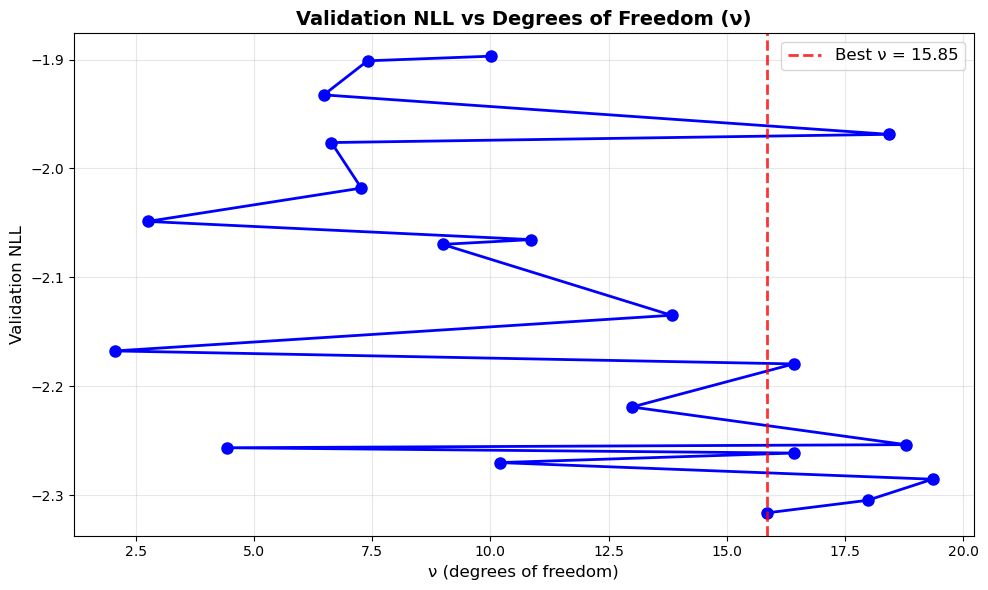


Summary:
  Best ν: 15.850
  Best Val NLL: -2.3163
  Corresponding Test NLL: -2.1758
  ν range tested: [2.06, 19.36]

ν grid search completed!
Results saved to: nu_grid_search_results.csv
Best model saved to: best_nu_t_distribution_model.pt
Recommended ν for 10-repeat training: 15.850241694880609


In [111]:
# -------------------------
# T-Distribution ν (Degrees of Freedom) Grid Search
# -------------------------


def grid_search_nu_parameter(X_train, y_train, X_val, y_val, X_test, y_test, fixed_config):
    """
    Grid search only for the degrees of freedom (ν) parameter
    All other hyperparameters are kept fixed
    """
    
    # Define ν values using uniform random sampling from 2-20
    np.random.seed(2025)  # For reproducibility
    n_random_samples = 20  # Number of random ν values to test
    nu_grid = np.random.uniform(2.0, 20.0, n_random_samples).tolist()
    nu_grid = sorted(nu_grid)  # Sort for cleaner output
    
    print(f"Grid Search for T-Distribution Degrees of Freedom (ν)")
    print(f"Using uniform random sampling from range [2.0, 20.0]")
    print(f"Fixed model configuration: {fixed_config}")
    print(f"ν values to test: {[f'{nu:.2f}' for nu in nu_grid]}")
    print(f"Total configurations: {len(nu_grid)}")
    print("=" * 70)
    
    results = []
    best_val_loss = float('inf')
    best_nu = None
    best_model_state = None
    
    for i, nu_value in enumerate(nu_grid):
        print(f"\nTesting ν = {nu_value:.3f} ({i+1}/{len(nu_grid)})")
        
        start_time = time.time()
        
        try:
            # Train model with current ν value
            model, train_losses, val_losses = train_fixed_t_model(
                X_train, y_train, X_val, y_val, X_test, y_test, 
                fixed_config, nu_fixed=nu_value
            )
            
            # Calculate metrics
            model.eval()
            with torch.no_grad():
                # Validation metrics
                mu_val, sigma_val, nu_val = model(X_val)
                val_nll = t_distribution_nll_loss(y_val, mu_val, sigma_val, nu_val).item()
                
                # Test metrics
                mu_test, sigma_test, nu_test = model(X_test)
                test_nll = t_distribution_nll_loss(y_test, mu_test, sigma_test, nu_test).item()
                
                # Additional metrics
                val_mae = torch.mean(torch.abs(y_val - mu_val)).item()
                test_mae = torch.mean(torch.abs(y_test - mu_test)).item()
                val_rmse = torch.sqrt(torch.mean((y_val - mu_val)**2)).item()
                test_rmse = torch.sqrt(torch.mean((y_test - mu_test)**2)).item()
                
                # Mean predicted sigma (uncertainty measure)
                mean_sigma_val = torch.mean(sigma_val).item()
                mean_sigma_test = torch.mean(sigma_test).item()
                std_sigma_val = torch.std(sigma_val).item()
                std_sigma_test = torch.std(sigma_test).item()
                
                # Log-likelihood per sample (for comparison)
                log_likelihood_val = -val_nll
                log_likelihood_test = -test_nll
                
                # Tail behavior analysis (how much probability in tails)
                # For t-distribution, lower ν means heavier tails
                tail_weight = 1.0 / nu_value  # Simple proxy for tail heaviness
            
            training_time = time.time() - start_time
            
            # Store results
            result = {
                'nu': nu_value,
                'val_nll': val_nll,
                'test_nll': test_nll,
                'val_mae': val_mae,
                'test_mae': test_mae,
                'val_rmse': val_rmse,
                'test_rmse': test_rmse,
                'mean_sigma_val': mean_sigma_val,
                'mean_sigma_test': mean_sigma_test,
                'std_sigma_val': std_sigma_val,
                'std_sigma_test': std_sigma_test,
                'log_likelihood_val': log_likelihood_val,
                'log_likelihood_test': log_likelihood_test,
                'tail_weight': tail_weight,
                'training_time': training_time,
                'converged': len(train_losses) < 2000,
                'final_train_loss': train_losses[-1],
                'final_val_loss': val_losses[-1]
            }
            
            results.append(result)
            
            # Check if this is the best model so far
            if val_nll < best_val_loss:
                best_val_loss = val_nll
                best_nu = nu_value
                best_model_state = copy.deepcopy(model.state_dict())
                print(f"*** NEW BEST ν *** ν = {nu_value:.3f}, Val NLL: {val_nll:.4f}")
            
            print(f"Val NLL: {val_nll:.4f}, Test NLL: {test_nll:.4f}")
            print(f"Mean σ (val/test): {mean_sigma_val:.4f}/{mean_sigma_test:.4f}")
            print(f"Training time: {training_time:.1f}s")
            
        except Exception as e:
            print(f"ν = {nu_value:.3f} failed: {str(e)}")
            # Store failed result
            result = {
                'nu': nu_value,
                'val_nll': float('inf'),
                'test_nll': float('inf'),
                'val_mae': float('inf'),
                'test_mae': float('inf'),
                'val_rmse': float('inf'),
                'test_rmse': float('inf'),
                'mean_sigma_val': float('nan'),
                'mean_sigma_test': float('nan'),
                'std_sigma_val': float('nan'),
                'std_sigma_test': float('nan'),
                'log_likelihood_val': float('-inf'),
                'log_likelihood_test': float('-inf'),
                'tail_weight': 1.0 / nu_value,
                'training_time': 0,
                'converged': False,
                'error': str(e)
            }
            results.append(result)
            continue
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Sort by validation NLL
    results_df = results_df.sort_values('val_nll').reset_index(drop=True)
    
    print(f"\n" + "="*70)
    print(f"ν GRID SEARCH COMPLETED")
    print(f"="*70)
    print(f"Best ν: {best_nu:.3f}")
    print(f"Best Validation NLL: {results_df.iloc[0]['val_nll']:.4f}")
    print(f"Corresponding Test NLL: {results_df.iloc[0]['test_nll']:.4f}")
    
    return results_df, best_nu, best_model_state

def analyze_nu_grid_search_results(results_df):
    """
    Analyze and visualize ν grid search results with single clear plot
    """
    print(f"\n" + "="*70)
    print(f"ν GRID SEARCH ANALYSIS")
    print(f"="*70)
    
    # All results table
    print(f"\nAll ν Results (sorted by Validation NLL):")
    display_cols = ['nu', 'val_nll', 'test_nll', 'mean_sigma_val', 'mean_sigma_test']
    print(results_df[display_cols].to_string(index=False, float_format='%.4f'))
    
    # Single clear visualization
    valid_results = results_df[results_df['val_nll'] != float('inf')].copy()
    best_nu = valid_results.loc[valid_results['val_nll'].idxmin(), 'nu']
    
    plt.figure(figsize=(10, 6))
    plt.plot(valid_results['nu'], valid_results['val_nll'], 'bo-', markersize=8, linewidth=2)
    plt.axvline(x=best_nu, color='red', linestyle='--', alpha=0.8, linewidth=2, 
                label=f'Best ν = {best_nu:.2f}')
    plt.title('Validation NLL vs Degrees of Freedom (ν)', fontsize=14, fontweight='bold')
    plt.xlabel('ν (degrees of freedom)', fontsize=12)
    plt.ylabel('Validation NLL', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig('nu_grid_search_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Summary statistics  
    print(f"\nSummary:")
    print(f"  Best ν: {best_nu:.3f}")
    print(f"  Best Val NLL: {valid_results['val_nll'].min():.4f}")
    print(f"  Corresponding Test NLL: {valid_results.loc[valid_results['val_nll'].idxmin(), 'test_nll']:.4f}")
    print(f"  ν range tested: [{min(valid_results['nu']):.2f}, {max(valid_results['nu']):.2f}]")
    
    return results_df

def run_nu_grid_search():
    """
    Main function to run the ν grid search with your fixed configuration
    """
    
    # Your fixed model configuration
    fixed_config = {
        "lstm_hidden_dim": 32,
        "n_hidden1": 32,
        "n_hidden2": 32,
        "lr": 0.002,
        "dropout": 0.01,
        "activation": "relu"
    }

    
    print("Starting ν (degrees of freedom) Grid Search for T-Distribution Model...")
    
    # Run grid search
    results_df, best_nu, best_model_state = grid_search_nu_parameter(
        X_train, y_train, X_val, y_val, X_test, y_test, fixed_config
    )
    
    # Analyze results
    results_df = analyze_nu_grid_search_results(results_df)
    
    # Save results
    results_df.to_csv('nu_grid_search_results.csv', index=False)
    
    # Save best model configuration
    torch.save({
        'config': fixed_config,
        'best_nu': best_nu,
        'model_state_dict': best_model_state
    }, 'best_nu_t_distribution_model.pt')
    
    print(f"\nν grid search completed!")
    print(f"Results saved to: nu_grid_search_results.csv")
    print(f"Best model saved to: best_nu_t_distribution_model.pt")
    print(f"Recommended ν for 10-repeat training: {best_nu}")
    
    return results_df, best_nu

# Usage:
results_df, best_nu = run_nu_grid_search()

## Other searching on df

Geometric ν search: ['1.50', '2.25', '3.38', '5.06', '7.59', '11.39', '17.09', '25.63']
Testing ν = 1.500 (1/8)
Epoch 100: Train NLL = -1.8966, Val NLL = -2.3207
Epoch 200: Train NLL = -1.9409, Val NLL = -2.3683
Early stopping at epoch 206
Test NLL: -2.1687
*** NEW BEST ν = 1.500, Val NLL = -2.3545 ***
Val NLL: -2.3545, Test NLL: -2.1687
Testing ν = 2.250 (2/8)
Epoch 100: Train NLL = -1.9262, Val NLL = -2.3489
Early stopping at epoch 195
Test NLL: -2.1637
Val NLL: -2.3446, Test NLL: -2.1637
Testing ν = 3.375 (3/8)
Epoch 100: Train NLL = -1.9139, Val NLL = -2.3072
Early stopping at epoch 196
Test NLL: -2.1844
Val NLL: -2.3538, Test NLL: -2.1844
Testing ν = 5.062 (4/8)
Epoch 100: Train NLL = -1.9152, Val NLL = -2.2763
Early stopping at epoch 194
Test NLL: -2.1787
Val NLL: -2.2893, Test NLL: -2.1787
Testing ν = 7.594 (5/8)
Epoch 100: Train NLL = -1.9117, Val NLL = -2.2860
Early stopping at epoch 181
Test NLL: -2.2099
Val NLL: -2.3187, Test NLL: -2.2099
Testing ν = 11.391 (6/8)
Epoch 100: 

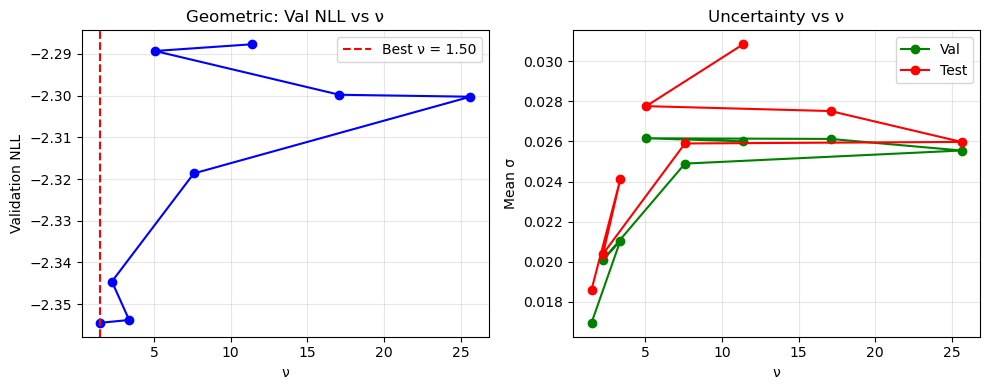

Beta-weighted ν search: ['3.92', '4.66', '5.33', '6.06', '6.55', '7.15', '8.58', '9.29', '11.58', '11.70', '12.22', '13.35', '16.03', '16.99', '17.18']
Testing ν = 3.916 (1/15)
Epoch 100: Train NLL = -1.9235, Val NLL = -2.2975
Early stopping at epoch 185
Test NLL: -2.2028
*** NEW BEST ν = 3.916, Val NLL = -2.3188 ***
Val NLL: -2.3188, Test NLL: -2.2028
Testing ν = 4.662 (2/15)
Epoch 100: Train NLL = -1.9195, Val NLL = -2.3347
Early stopping at epoch 170
Test NLL: -2.2110
*** NEW BEST ν = 4.662, Val NLL = -2.3431 ***
Val NLL: -2.3431, Test NLL: -2.2110
Testing ν = 5.330 (3/15)
Epoch 100: Train NLL = -1.9073, Val NLL = -2.2880
Early stopping at epoch 191
Test NLL: -2.2063
*** NEW BEST ν = 5.330, Val NLL = -2.3487 ***
Val NLL: -2.3487, Test NLL: -2.2063
Testing ν = 6.059 (4/15)
Epoch 100: Train NLL = -1.9283, Val NLL = -2.2374
Epoch 200: Train NLL = -1.9732, Val NLL = -2.3414
Early stopping at epoch 242
Test NLL: -2.1693
Val NLL: -2.3426, Test NLL: -2.1693
Testing ν = 6.552 (5/15)
Epoch 1

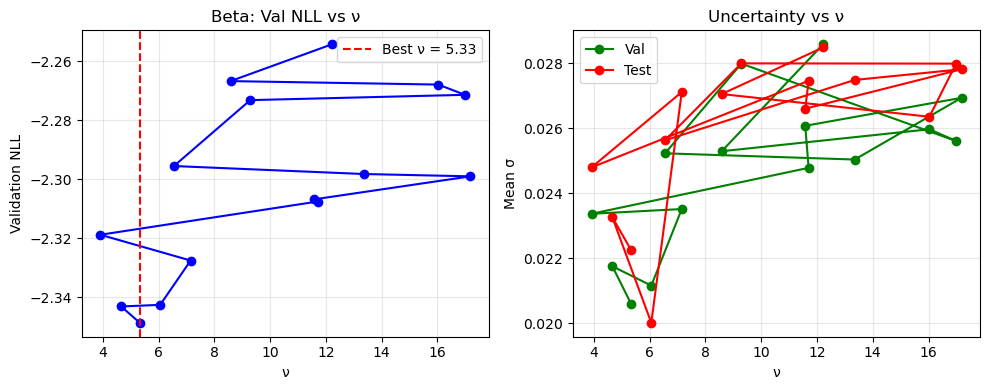

In [75]:
# -------------------------
# Smart ν Tuning Methods 
# -------------------------

def geometric_progression_nu_search(X_train, y_train, X_val, y_val, X_test, y_test, fixed_config):
    """Geometric progression ν search (1.5x multiplication)"""
    
    # Generate ν grid
    nu_grid = []
    current_nu = 1.5
    while current_nu <= 30.0:
        nu_grid.append(current_nu)
        current_nu *= 1.5
    
    print(f"Geometric ν search: {[f'{nu:.2f}' for nu in nu_grid]}")
    
    return _run_nu_search(X_train, y_train, X_val, y_val, X_test, y_test, fixed_config, nu_grid)

def beta_weighted_nu_search(X_train, y_train, X_val, y_val, X_test, y_test, fixed_config):
    """Beta-weighted ν sampling (focuses on low values)"""
    
    # Generate beta-weighted samples
    np.random.seed(42)
    beta_samples = np.random.beta(2, 5, 15)
    nu_grid = sorted(1.5 + (30.0 - 1.5) * beta_samples)
    
    print(f"Beta-weighted ν search: {[f'{nu:.2f}' for nu in nu_grid]}")
    
    return _run_nu_search(X_train, y_train, X_val, y_val, X_test, y_test, fixed_config, nu_grid)

def _run_nu_search(X_train, y_train, X_val, y_val, X_test, y_test, fixed_config, nu_grid):
    """Core ν search function"""
    
    results = []
    best_val_loss = float('inf')
    best_nu = None
    
    for i, nu_value in enumerate(nu_grid):
        print(f"Testing ν = {nu_value:.3f} ({i+1}/{len(nu_grid)})")
        
        try:
            # Train model
            model, train_losses, val_losses = train_fixed_t_model(
                X_train, y_train, X_val, y_val, X_test, y_test, 
                fixed_config, nu_fixed=nu_value
            )
            
            # Evaluate
            model.eval()
            with torch.no_grad():
                mu_val, sigma_val, nu_val = model(X_val)
                val_nll = t_distribution_nll_loss(y_val, mu_val, sigma_val, nu_val).item()
                
                mu_test, sigma_test, nu_test = model(X_test)
                test_nll = t_distribution_nll_loss(y_test, mu_test, sigma_test, nu_test).item()
            
            # Store results
            result = {
                'nu': nu_value,
                'val_nll': val_nll,
                'test_nll': test_nll,
                'mean_sigma_val': torch.mean(sigma_val).item(),
                'mean_sigma_test': torch.mean(sigma_test).item()
            }
            results.append(result)
            
            # Track best
            if val_nll < best_val_loss:
                best_val_loss = val_nll
                best_nu = nu_value
                print(f"*** NEW BEST ν = {nu_value:.3f}, Val NLL = {val_nll:.4f} ***")
            
            print(f"Val NLL: {val_nll:.4f}, Test NLL: {test_nll:.4f}")
            
        except Exception as e:
            print(f"Failed: {str(e)}")
            results.append({
                'nu': nu_value, 'val_nll': float('inf'), 'test_nll': float('inf'),
                'mean_sigma_val': float('nan'), 'mean_sigma_test': float('nan')
            })
    
    # Process results
    results_df = pd.DataFrame(results).sort_values('val_nll').reset_index(drop=True)
    
    print(f"Best ν: {best_nu:.3f}, Best Val NLL: {results_df.iloc[0]['val_nll']:.4f}")
    
    return results_df, best_nu

def plot_nu_results(results_df, method_name):
    """Plot ν search results"""
    
    valid_results = results_df[results_df['val_nll'] != float('inf')]
    best_nu = valid_results.iloc[0]['nu']
    
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(valid_results['nu'], valid_results['val_nll'], 'bo-')
    plt.axvline(x=best_nu, color='red', linestyle='--', label=f'Best ν = {best_nu:.2f}')
    plt.title(f'{method_name}: Val NLL vs ν')
    plt.xlabel('ν')
    plt.ylabel('Validation NLL')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(valid_results['nu'], valid_results['mean_sigma_val'], 'go-', label='Val')
    plt.plot(valid_results['nu'], valid_results['mean_sigma_test'], 'ro-', label='Test')
    plt.xlabel('ν')
    plt.ylabel('Mean σ')
    plt.title('Uncertainty vs ν')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{method_name.lower()}_nu_results.png', dpi=300)
    plt.show()

def compare_nu_methods(X_train, y_train, X_val, y_val, X_test, y_test, fixed_config):
    """Compare both ν search methods"""
    
    print("COMPARING ν METHODS")
    print("=" * 50)
    
    # Run both methods
    print("\n1. GEOMETRIC PROGRESSION")
    results_geom, best_nu_geom = geometric_progression_nu_search(
        X_train, y_train, X_val, y_val, X_test, y_test, fixed_config
    )
    plot_nu_results(results_geom, "Geometric")
    
    print("\n2. BETA-WEIGHTED SAMPLING")
    results_beta, best_nu_beta = beta_weighted_nu_search(
        X_train, y_train, X_val, y_val, X_test, y_test, fixed_config
    )
    plot_nu_results(results_beta, "Beta")
    
    # Compare
    geom_best_nll = results_geom.iloc[0]['val_nll']
    beta_best_nll = results_beta.iloc[0]['val_nll']
    
    print(f"\nRESULTS:")
    print(f"Geometric: ν={best_nu_geom:.3f}, NLL={geom_best_nll:.4f}")
    print(f"Beta:      ν={best_nu_beta:.3f}, NLL={beta_best_nll:.4f}")
    
    if geom_best_nll < beta_best_nll:
        winner = "Geometric"
        recommended_nu = best_nu_geom
    else:
        winner = "Beta"
        recommended_nu = best_nu_beta
    
    print(f"WINNER: {winner}")
    print(f"Recommended ν: {recommended_nu:.3f}")
    
    return recommended_nu

# Usage functions
def run_geometric_search():
    """Run geometric ν search"""
    fixed_config = {
        "lstm_hidden_dim": 64, "n_hidden1": 64, "n_hidden2": 64, 
        "lr": 0.005, "dropout": 0.1, "activation": "elu"
    }
    
    results_df, best_nu = geometric_progression_nu_search(
        X_train, y_train, X_val, y_val, X_test, y_test, fixed_config
    )
    plot_nu_results(results_df, "Geometric")
    return results_df, best_nu

def run_beta_search():
    """Run beta-weighted ν search"""
    fixed_config = {
        "lstm_hidden_dim": 64, "n_hidden1": 64, "n_hidden2": 64, 
        "lr": 0.005, "dropout": 0.1, "activation": "elu"
    }
    
    results_df, best_nu = beta_weighted_nu_search(
        X_train, y_train, X_val, y_val, X_test, y_test, fixed_config
    )
    plot_nu_results(results_df, "Beta")
    return results_df, best_nu

def run_comparison():
    """Compare both methods"""
    fixed_config = {
        "lstm_hidden_dim": 64, "n_hidden1": 64, "n_hidden2": 64, 
        "lr": 0.005, "dropout": 0.1, "activation": "elu"
    }
    
    return compare_nu_methods(X_train, y_train, X_val, y_val, X_test, y_test, fixed_config)

# Usage:
results_df, best_nu = run_geometric_search()  # Supervisor's method
results_df, best_nu = run_beta_search()       # Alternative
# recommended_nu = run_comparison()             # Compare both

## 4. Modelling with 10 repeats on best v


=== T-Dist Run 1/10 ===
Test NLL: -2.0842
Test MAE = 0.0212, MSE = 0.0008, NLL = -2.0842

=== T-Dist Run 2/10 ===
Test NLL: -2.1299
Test MAE = 0.0219, MSE = 0.0009, NLL = -2.1299

=== T-Dist Run 3/10 ===
Test NLL: -2.1811
Test MAE = 0.0207, MSE = 0.0008, NLL = -2.1811

=== T-Dist Run 4/10 ===
Test NLL: -2.1679
Test MAE = 0.0210, MSE = 0.0008, NLL = -2.1679

=== T-Dist Run 5/10 ===
Test NLL: -2.1607
Test MAE = 0.0212, MSE = 0.0008, NLL = -2.1607

=== T-Dist Run 6/10 ===
Test NLL: -2.1930
Test MAE = 0.0204, MSE = 0.0008, NLL = -2.1930

=== T-Dist Run 7/10 ===
Test NLL: -2.0898
Test MAE = 0.0211, MSE = 0.0008, NLL = -2.0898

=== T-Dist Run 8/10 ===
Test NLL: -2.1431
Test MAE = 0.0209, MSE = 0.0008, NLL = -2.1431

=== T-Dist Run 9/10 ===
Test NLL: -2.1495
Test MAE = 0.0207, MSE = 0.0008, NLL = -2.1495

=== T-Dist Run 10/10 ===
Test NLL: -2.1896
Test MAE = 0.0205, MSE = 0.0008, NLL = -2.1896

=== T-Dist Run 11/10 ===
Test NLL: -2.1529
Test MAE = 0.0214, MSE = 0.0008, NLL = -2.1529

=== T-D

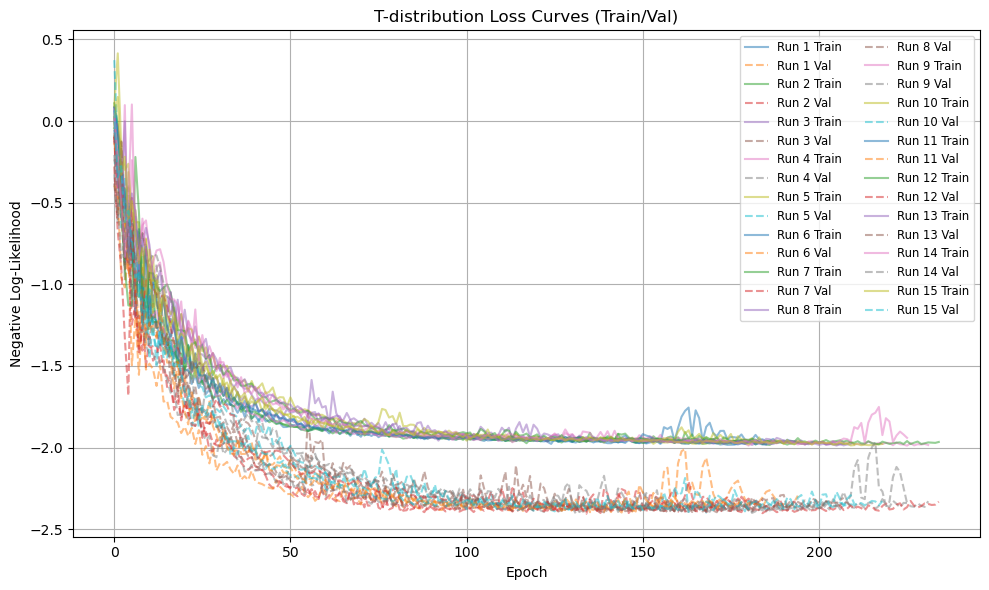


Best run: 6 with Test NLL = -2.1930


In [240]:
# -------------------------
# 1. Define T-Density LSTM Model with Fixed Nu
# -------------------------
class TDistributionDensityNetworkWithLSTM(nn.Module):
    def __init__(self, input_dim, seq_length, lstm_hidden_dim, n_hidden1, n_hidden2, 
                 dropout=0.1, activation="relu", fixed_nu=2.751):
        super().__init__()
        self.fixed_nu = fixed_nu  # Store the fixed nu value
        self.lstm = nn.LSTM(input_dim, lstm_hidden_dim, batch_first=True)

        def make_layer(in_f, out_f):
            layers = [nn.Linear(in_f, out_f)]
            if activation.lower() == "relu":
                layers.append(nn.ReLU())
            elif activation.lower() == "leaky_relu":
                layers.append(nn.LeakyReLU())
            elif activation.lower() == "elu":
                layers.append(nn.ELU())
            else:
                layers.append(nn.ReLU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            return nn.Sequential(*layers)

        self.hidden_layer1 = make_layer(lstm_hidden_dim, n_hidden1)
        self.hidden_layer2 = make_layer(n_hidden1, n_hidden2)
        self.mu_layer = nn.Linear(n_hidden2, 1)
        self.sigma_layer = nn.Linear(n_hidden2, 1)
        # Remove nu_layer since we're using fixed nu

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(1, batch_size, self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(1, batch_size, self.lstm.hidden_size).to(x.device)
        lstm_out, _ = self.lstm(x, (h0, c0))
        out = lstm_out[:, -1, :]
        out = self.hidden_layer1(out)
        out = self.hidden_layer2(out)
        mu = self.mu_layer(out)
        sigma = torch.exp(self.sigma_layer(out))
        # Use fixed nu value for all predictions
        nu = torch.full_like(mu, self.fixed_nu)
        return mu, sigma, nu

# 2. T-distribution Loss
# -------------------------
def t_distribution_nll_loss(y, mu, sigma, nu):
    term1 = torch.log(sigma)
    term2 = 0.5 * torch.log(nu * torch.pi)
    term3 = torch.lgamma(nu / 2)
    term4 = -torch.lgamma((nu + 1) / 2)
    term5 = (nu + 1) / 2 * torch.log(1 + ((y - mu) / sigma)**2 / nu)
    return (term1 + term2 + term3 + term4 + term5).mean()

def init_weights(model):
    for name, param in model.named_parameters():
        if 'weight' in name and param.dim() >= 2:
            nn.init.xavier_normal_(param)
        elif 'bias' in name:
            nn.init.zeros_(param)
            if 'sigma_layer.bias' in name:
                nn.init.constant_(param, -1.0)

manual_config = {
    "lstm_hidden_dim": 64,
    "n_hidden1": 64,
    "n_hidden2": 64,
    "lr": 0.005,
    "dropout": 0.1,
    "activation": "elu",
    "fixed_nu": 2.751  # Add fixed nu to config
}

# Update the training function to pass fixed_nu
def train_t_model(X_train, y_train, X_val, y_val, X_test, y_test, config):
    model = TDistributionDensityNetworkWithLSTM(
        input_dim=X_train.shape[2],
        seq_length=X_train.shape[1],
        lstm_hidden_dim=config["lstm_hidden_dim"],
        n_hidden1=config["n_hidden1"],
        n_hidden2=config["n_hidden2"],
        dropout=config["dropout"],
        activation=config["activation"],
        fixed_nu=config["fixed_nu"]  # Pass fixed nu
    )
    init_weights(model)
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])
    
    best_val_loss = float("inf")
    patience = 50
    patience_counter = 0
    train_losses, val_losses = [], []

    for epoch in range(2000):
        model.train()
        optimizer.zero_grad()
        mu, sigma, nu = model(X_train)
        loss = t_distribution_nll_loss(y_train, mu, sigma, nu)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            mu_val, sigma_val, nu_val = model(X_val)
            val_loss = t_distribution_nll_loss(y_val, mu_val, sigma_val, nu_val)
            val_losses.append(val_loss.item())

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    model.load_state_dict(best_model_state)
    model.eval()
    with torch.no_grad():
        mu_test, sigma_test, nu_test = model(X_test)
        test_loss = t_distribution_nll_loss(y_test, mu_test, sigma_test, nu_test)

    print(f"Test NLL: {test_loss.item():.4f}")
    return model, train_losses, val_losses


def compute_metrics_t(y_true, mu, sigma, nu):
    mae = torch.mean(torch.abs(y_true - mu)).item()
    mse = torch.mean((y_true - mu)**2).item()
    nll = t_distribution_nll_loss(y_true, mu, sigma, nu).item()
    return mae, mse, nll

all_run_metrics_t = []
all_run_predictions_t = []
all_run_losses_t = []
all_run_sigmas_t = []
all_run_nus_t = []

for run in range(15):
    print(f"\n=== T-Dist Run {run+1}/10 ===")
    torch.manual_seed(run + 1)
    np.random.seed(run + 1)
    
    model, train_losses, val_losses = train_t_model(X_train, y_train, X_val, y_val, X_test, y_test, manual_config)

    with torch.no_grad():
        mu_test, sigma_test, nu_test = model(X_test)
        metrics = compute_metrics_t(y_test, mu_test, sigma_test, nu_test)

    print(f"Test MAE = {metrics[0]:.4f}, MSE = {metrics[1]:.4f}, NLL = {metrics[2]:.4f}")
    
    all_run_metrics_t.append(metrics)
    all_run_predictions_t.append(mu_test.cpu().numpy())
    all_run_losses_t.append((train_losses, val_losses))
    all_run_sigmas_t.append(sigma_test.cpu().numpy())
    all_run_nus_t.append(nu_test.cpu().numpy())

# -------------------------
# 5. Plot Loss Curves
# -------------------------
plt.figure(figsize=(10, 6))
for i, (train_loss, val_loss) in enumerate(all_run_losses_t):
    plt.plot(train_loss, label=f"Run {i+1} Train", alpha=0.5)
    plt.plot(val_loss, label=f"Run {i+1} Val", linestyle="--", alpha=0.5)
plt.xlabel("Epoch")
plt.ylabel("Negative Log-Likelihood")
plt.title("T-distribution Loss Curves (Train/Val)")
plt.legend(fontsize="small", ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------
# 6. Best Run
# -------------------------
best_run_idx = np.argmin([m[2] for m in all_run_metrics_t])
print(f"\nBest run: {best_run_idx + 1} with Test NLL = {all_run_metrics_t[best_run_idx][2]:.4f}")


Starting 10-Repeat Training with Fixed ν = 2.37

=== Fixed ν T-Dist Run 1/10 ===
Test NLL: -2.1065, Mean ν: 2.370
Test MAE = 0.0222, MSE = 0.0009, NLL = -2.1065
Mean σ = 0.0205, Std σ = 0.0054, ν = 2.370

=== Fixed ν T-Dist Run 2/10 ===
Test NLL: -2.1570, Mean ν: 2.370
Test MAE = 0.0210, MSE = 0.0008, NLL = -2.1570
Mean σ = 0.0182, Std σ = 0.0044, ν = 2.370

=== Fixed ν T-Dist Run 3/10 ===
Test NLL: -2.1955, Mean ν: 2.370
Test MAE = 0.0204, MSE = 0.0008, NLL = -2.1955
Mean σ = 0.0205, Std σ = 0.0047, ν = 2.370

=== Fixed ν T-Dist Run 4/10 ===
Test NLL: -2.1890, Mean ν: 2.370
Test MAE = 0.0204, MSE = 0.0008, NLL = -2.1890
Mean σ = 0.0195, Std σ = 0.0045, ν = 2.370

=== Fixed ν T-Dist Run 5/10 ===
Test NLL: -2.2046, Mean ν: 2.370
Test MAE = 0.0201, MSE = 0.0008, NLL = -2.2046
Mean σ = 0.0198, Std σ = 0.0043, ν = 2.370

=== Fixed ν T-Dist Run 6/10 ===
Test NLL: -2.1909, Mean ν: 2.370
Test MAE = 0.0204, MSE = 0.0008, NLL = -2.1909
Mean σ = 0.0205, Std σ = 0.0047, ν = 2.370

=== Fixed ν T-D

/var/folders/0k/3jhs8p2d2bdd3_fvs731s4cr0000gn/T/ipykernel_2481/4079528143.py:217: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0,1].boxplot([mae_values, nll_values], labels=['MAE', 'NLL'])


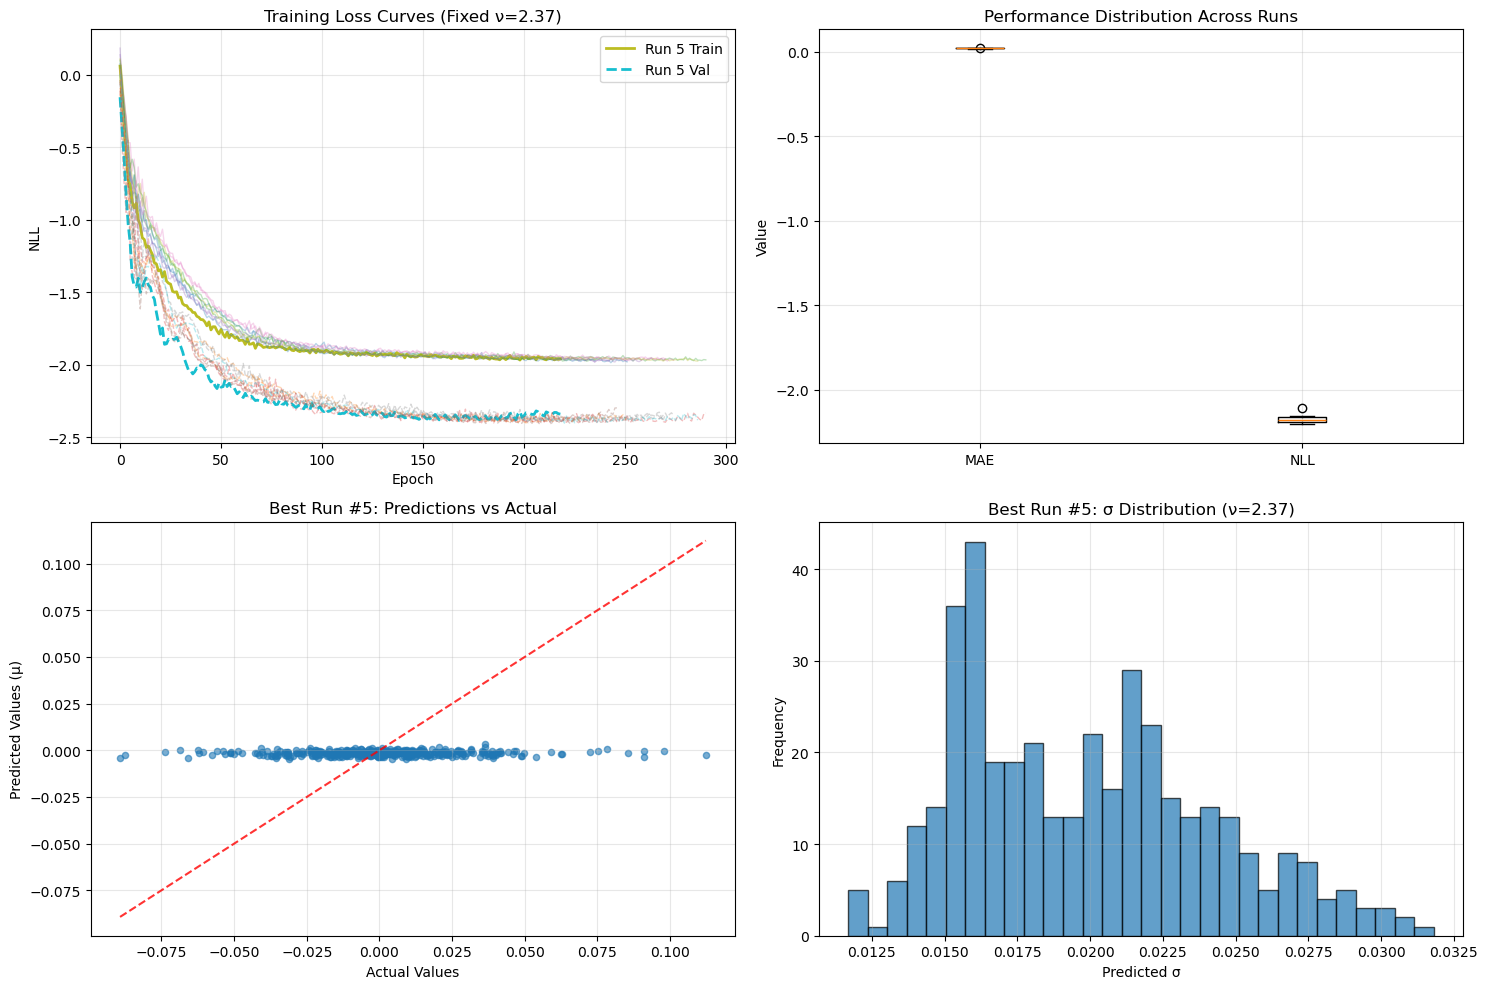


Model now uses fixed ν = 2.37 (from grid search) and only models μ and σ
Results saved to: fixed_nu_t_distribution_10_repeats.png


In [81]:
# -------------------------
# 1. Define T-Density LSTM Model with Fixed ν=2.37
# -------------------------
class FixedTDensityNetworkWithLSTM(nn.Module):
    def __init__(self, input_dim, seq_length, lstm_hidden_dim, n_hidden1, n_hidden2, 
                 dropout=0.1, activation="relu", nu_fixed=2.37):
        super().__init__()
        
        self.nu_fixed = torch.tensor(nu_fixed, dtype=torch.float32)
        self.lstm = nn.LSTM(input_dim, lstm_hidden_dim, batch_first=True)

        def make_layer(in_f, out_f):
            layers = [nn.Linear(in_f, out_f)]
            if activation.lower() == "relu":
                layers.append(nn.ReLU())
            elif activation.lower() == "leaky_relu":
                layers.append(nn.LeakyReLU())
            elif activation.lower() == "elu":
                layers.append(nn.ELU())
            else:
                layers.append(nn.ReLU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            return nn.Sequential(*layers)

        self.hidden_layer1 = make_layer(lstm_hidden_dim, n_hidden1)
        self.hidden_layer2 = make_layer(n_hidden1, n_hidden2)
        self.mu_layer = nn.Linear(n_hidden2, 1)
        self.sigma_layer = nn.Linear(n_hidden2, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(1, batch_size, self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(1, batch_size, self.lstm.hidden_size).to(x.device)
        lstm_out, _ = self.lstm(x, (h0, c0))
        out = lstm_out[:, -1, :]
        out = self.hidden_layer1(out)
        out = self.hidden_layer2(out)
        mu = self.mu_layer(out)
        sigma = torch.exp(self.sigma_layer(out))  # ensures positivity
        nu = torch.full_like(mu, self.nu_fixed)   # Fixed ν=2.37 for all samples
        return mu, sigma, nu

# -------------------------
# 2. T-distribution Loss (same as before)
# -------------------------
def t_distribution_nll_loss(y, mu, sigma, nu):
    term1 = torch.log(sigma)
    term2 = 0.5 * torch.log(nu * torch.pi)
    term3 = torch.lgamma(nu / 2)
    term4 = -torch.lgamma((nu + 1) / 2)
    term5 = (nu + 1) / 2 * torch.log(1 + ((y - mu) / sigma)**2 / nu)
    return (term1 + term2 + term3 + term4 + term5).mean()

def init_weights(model):
    for name, param in model.named_parameters():
        if 'weight' in name and param.dim() >= 2:
            nn.init.xavier_normal_(param)
        elif 'bias' in name:
            nn.init.zeros_(param)
            if 'sigma_layer.bias' in name:
                nn.init.constant_(param, -1.0)

# -------------------------
# 3. Training Function with Fixed ν
# -------------------------
def train_fixed_t_model(X_train, y_train, X_val, y_val, X_test, y_test, config, nu_fixed=2.37):
    model = FixedTDensityNetworkWithLSTM(
        input_dim=X_train.shape[2],
        seq_length=X_train.shape[1],
        lstm_hidden_dim=config["lstm_hidden_dim"],
        n_hidden1=config["n_hidden1"],
        n_hidden2=config["n_hidden2"],
        dropout=config["dropout"],
        activation=config["activation"],
        nu_fixed=nu_fixed
    )
    init_weights(model)
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])
    
    best_val_loss = float("inf")
    patience = 50
    patience_counter = 0
    train_losses, val_losses = [], []

    for epoch in range(2000):
        model.train()
        optimizer.zero_grad()
        mu, sigma, nu = model(X_train)
        loss = t_distribution_nll_loss(y_train, mu, sigma, nu)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            mu_val, sigma_val, nu_val = model(X_val)
            val_loss = t_distribution_nll_loss(y_val, mu_val, sigma_val, nu_val)
            val_losses.append(val_loss.item())

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    model.load_state_dict(best_model_state)
    model.eval()
    with torch.no_grad():
        mu_test, sigma_test, nu_test = model(X_test)
        test_loss = t_distribution_nll_loss(y_test, mu_test, sigma_test, nu_test)

    print(f"Test NLL: {test_loss.item():.4f}, Mean ν: {torch.mean(nu_test).item():.3f}")
    return model, train_losses, val_losses

# -------------------------
# 4. Run 10 Repeats with Fixed ν=2.37
# -------------------------
manual_config = {
    "lstm_hidden_dim": 32,
    "n_hidden1": 32,
    "n_hidden2": 32,
    "lr": 0.005,
    "dropout": 0.1,
    "activation": "elu"
}

def compute_metrics_fixed_t(y_true, mu, sigma, nu):
    mae = torch.mean(torch.abs(y_true - mu)).item()
    mse = torch.mean((y_true - mu)**2).item()
    nll = t_distribution_nll_loss(y_true, mu, sigma, nu).item()
    mean_sigma = torch.mean(sigma).item()
    std_sigma = torch.std(sigma).item()
    mean_nu = torch.mean(nu).item()
    return mae, mse, nll, mean_sigma, std_sigma, mean_nu

print(f"Starting 10-Repeat Training with Fixed ν = 2.37")
print("=" * 60)

all_run_metrics_fixed_t = []
all_run_predictions_fixed_t = []
all_run_losses_fixed_t = []
all_run_sigmas_fixed_t = []

for run in range(10):
    print(f"\n=== Fixed ν T-Dist Run {run+1}/10 ===")
    torch.manual_seed(run + 1)
    np.random.seed(run + 1)
    
    model, train_losses, val_losses = train_fixed_t_model(
        X_train, y_train, X_val, y_val, X_test, y_test, manual_config, nu_fixed=2.37
    )

    with torch.no_grad():
        mu_test, sigma_test, nu_test = model(X_test)
        metrics = compute_metrics_fixed_t(y_test, mu_test, sigma_test, nu_test)

    print(f"Test MAE = {metrics[0]:.4f}, MSE = {metrics[1]:.4f}, NLL = {metrics[2]:.4f}")
    print(f"Mean σ = {metrics[3]:.4f}, Std σ = {metrics[4]:.4f}, ν = {metrics[5]:.3f}")
    
    all_run_metrics_fixed_t.append(metrics)
    all_run_predictions_fixed_t.append(mu_test.cpu().numpy())
    all_run_losses_fixed_t.append((train_losses, val_losses))
    all_run_sigmas_fixed_t.append(sigma_test.cpu().numpy())

# -------------------------
# 5. Results Analysis
# -------------------------
print(f"\n" + "="*60)
print(f"10-REPEAT RESULTS SUMMARY (Fixed ν = 2.37)")
print(f"="*60)

metrics_array = np.array(all_run_metrics_fixed_t)
mae_values = metrics_array[:, 0]
mse_values = metrics_array[:, 1]
nll_values = metrics_array[:, 2]
mean_sigma_values = metrics_array[:, 3]
std_sigma_values = metrics_array[:, 4]

print(f"\nTest Performance Across 10 Runs:")
print(f"MAE  - Mean: {np.mean(mae_values):.4f}, Std: {np.std(mae_values):.4f}, Range: [{np.min(mae_values):.4f}, {np.max(mae_values):.4f}]")
print(f"MSE  - Mean: {np.mean(mse_values):.4f}, Std: {np.std(mse_values):.4f}, Range: [{np.min(mse_values):.4f}, {np.max(mse_values):.4f}]")
print(f"NLL  - Mean: {np.mean(nll_values):.4f}, Std: {np.std(nll_values):.4f}, Range: [{np.min(nll_values):.4f}, {np.max(nll_values):.4f}]")
print(f"Mean σ - Mean: {np.mean(mean_sigma_values):.4f}, Std: {np.std(mean_sigma_values):.4f}")

# Best run
best_run_idx = np.argmin(nll_values)
print(f"\nBest Run: #{best_run_idx + 1}")
print(f"  Test NLL: {nll_values[best_run_idx]:.4f}")
print(f"  Test MAE: {mae_values[best_run_idx]:.4f}")
print(f"  Test MSE: {mse_values[best_run_idx]:.4f}")
print(f"  Mean σ: {mean_sigma_values[best_run_idx]:.4f}")

# -------------------------
# 6. Visualization
# -------------------------
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss curves
axes[0,0].set_title('Training Loss Curves (Fixed ν=2.37)')
for i, (train_loss, val_loss) in enumerate(all_run_losses_fixed_t):
    alpha = 1.0 if i == best_run_idx else 0.3
    linewidth = 2 if i == best_run_idx else 1
    axes[0,0].plot(train_loss, alpha=alpha, linewidth=linewidth, 
                   label=f"Run {i+1} Train" if i == best_run_idx else "")
    axes[0,0].plot(val_loss, linestyle="--", alpha=alpha, linewidth=linewidth,
                   label=f"Run {i+1} Val" if i == best_run_idx else "")
axes[0,0].set_xlabel("Epoch")
axes[0,0].set_ylabel("NLL")
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Performance metrics distribution
axes[0,1].boxplot([mae_values, nll_values], labels=['MAE', 'NLL'])
axes[0,1].set_title('Performance Distribution Across Runs')
axes[0,1].set_ylabel('Value')
axes[0,1].grid(True, alpha=0.3)

# Mean predictions vs actual (best run)
y_true_flat = y_test.cpu().numpy().flatten()
best_pred = all_run_predictions_fixed_t[best_run_idx].flatten()
axes[1,0].scatter(y_true_flat, best_pred, alpha=0.6, s=20)
axes[1,0].plot([y_true_flat.min(), y_true_flat.max()], 
               [y_true_flat.min(), y_true_flat.max()], 'r--', alpha=0.8)
axes[1,0].set_xlabel('Actual Values')
axes[1,0].set_ylabel('Predicted Values (μ)')
axes[1,0].set_title(f'Best Run #{best_run_idx+1}: Predictions vs Actual')
axes[1,0].grid(True, alpha=0.3)

# Sigma distribution (best run)
best_sigmas = all_run_sigmas_fixed_t[best_run_idx].flatten()
axes[1,1].hist(best_sigmas, bins=30, alpha=0.7, edgecolor='black')
axes[1,1].set_xlabel('Predicted σ')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title(f'Best Run #{best_run_idx+1}: σ Distribution (ν=2.37)')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('fixed_nu_t_distribution_10_repeats.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nModel now uses fixed ν = 2.37 (from grid search) and only models μ and σ")
print(f"Results saved to: fixed_nu_t_distribution_10_repeats.png")

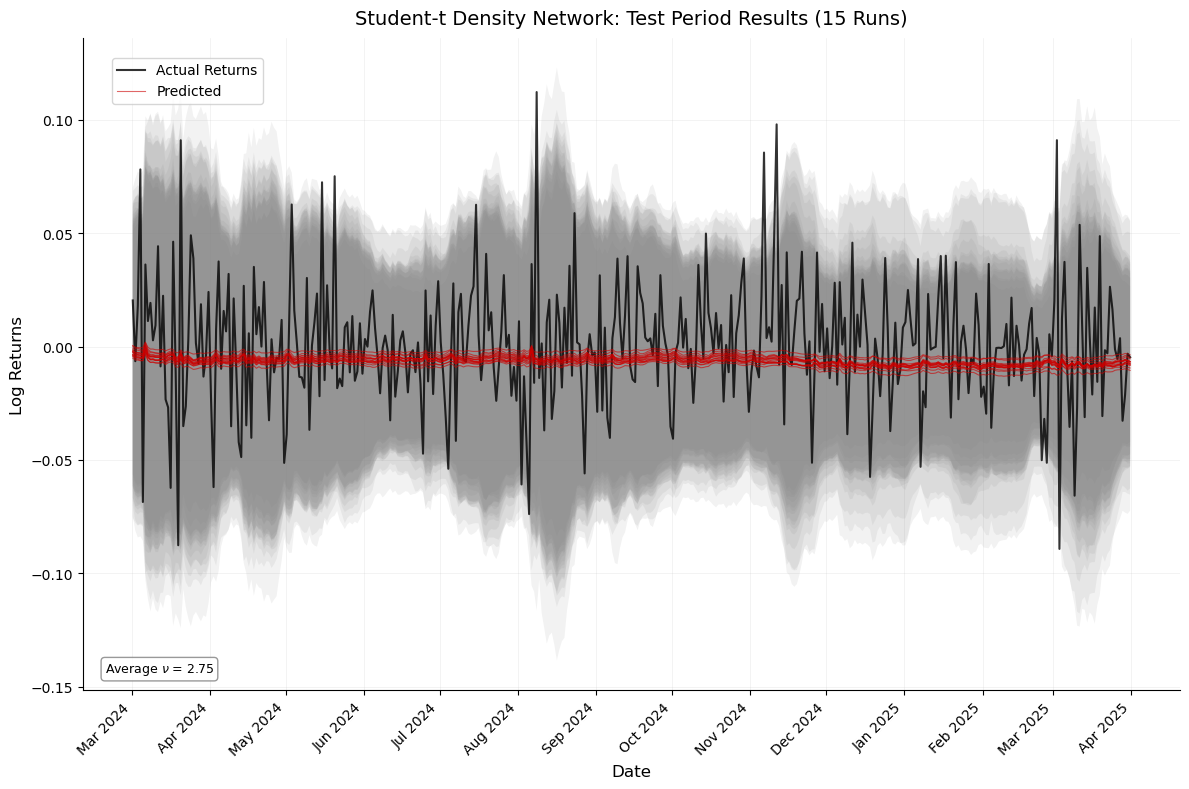

In [242]:
# -------------------------
# Get dates for test period using standard split
# -------------------------
seq_length = 3
n_all = len(X_all)
train_size = 0.7
val_size = 0.15

train_end = int(n_all * train_size)
val_end = train_end + int(n_all * val_size)
test_start_idx = val_end

# Get all dates (excluding the first seq_length rows used for sequence creation)
all_dates = pd.to_datetime(df_copy['Date'].iloc[seq_length:seq_length+n_all].values)

# Get test dates
test_dates = all_dates[test_start_idx:]

# Filter test data to start from Feb 2024
start_date = pd.to_datetime('2024-02-01')
test_mask = test_dates >= start_date
filtered_test_dates = test_dates[test_mask]

# -------------------------
# Plot all 15 fitted runs using T-distribution CI
# -------------------------
num_runs = 15
fig, ax = plt.subplots(figsize=(12, 8))

# Color scheme - matching thesis style
actual_color = '#000000'  # Black for actual
pred_color = '#CC0000'    # Red for predictions
ci_color = '#808080'      # Gray for confidence intervals

# Ground truth (filtered)
ax.plot(filtered_test_dates, y_test.cpu().numpy()[test_mask], color=actual_color, 
        linewidth=1.5, alpha=0.8, label='Actual Returns')

# Plot each run
for run in range(num_runs):
    prediction = all_run_predictions_t[run].flatten()[test_mask]
    sigma = all_run_sigmas_t[run].flatten()[test_mask]
    nu = all_run_nus_t[run].flatten()[test_mask]
    
    # Compute t-multiplier for 90% CI (changed from 85%)
    t_multiplier = t.ppf(0.95, df=np.clip(nu, 1.1, None))
    lower_bound = prediction - t_multiplier * sigma
    upper_bound = prediction + t_multiplier * sigma
    
    # Plot prediction with red color
    label = 'Predicted' if run == 0 else None
    ax.plot(filtered_test_dates, prediction, color=pred_color, 
            linewidth=0.8, alpha=0.6, label=label)
    
    # Plot confidence interval with gray
    ax.fill_between(filtered_test_dates, lower_bound, upper_bound, 
                    color=ci_color, alpha=0.1, linewidth=0, edgecolor='none')

# Formatting
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Log Returns', fontsize=12)
ax.set_title('Student-t Density Network: Test Period Results (15 Runs)', 
            fontsize=14, pad=10)

# Date formatting
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
test_range_days = (filtered_test_dates[-1] - filtered_test_dates[0]).days
if test_range_days > 60:
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
else:
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))

plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Grid and spines
ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Legend
ax.legend(loc='upper left', fontsize=10, frameon=True, 
         bbox_to_anchor=(0.02, 0.98))

# Add note about degrees of freedom
ax.text(0.02, 0.02, f'Average $\\nu$ = {np.mean([np.mean(all_run_nus_t[i][test_mask]) for i in range(num_runs)]):.2f}',
        transform=ax.transAxes, fontsize=9, verticalalignment='bottom',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                 edgecolor='gray', alpha=0.8))

# Adjust layout and save
plt.tight_layout()
plt.savefig('thesis_TDN_repets.png', dpi=300, bbox_inches='tight')
plt.show()

STUDENT-T DISTRIBUTION NETWORK - 25 REPEATS MODEL SELECTION
WITH LAYERNORM & LR SCHEDULING
COMPOSITE SCORING: 60% Coverage + 40% NLL (Averaged across quantiles)
Data shapes - Train: torch.Size([1840, 3, 7]), Val: torch.Size([394, 3, 7]), Test: torch.Size([396, 3, 7])
Using fixed ν = 2.751
Architecture: LSTM(64) -> Hidden(64, 64)
Learning rate: 0.005
Dropout: 0.1
Activation: elu

Training 25 TDN models...
Repeat  1: Score=0.6614 | Train=0.6633 Val=0.6576 Test=0.6645 | NLL: Train=1.0091 Val=1.0084 Test=1.0086
Repeat  2: Score=0.6598 | Train=0.6576 Val=0.6617 Test=0.6595 | NLL: Train=1.0091 Val=1.0084 Test=1.0086
Repeat  3: Score=-3.1133 | Train=-2.0094 Val=-3.9749 Test=-3.0685 | NLL: Train=-1.9964 Val=-2.3761 Test=-2.1873
Repeat  4: Score=0.6646 | Train=0.6645 Val=0.6656 Test=0.6634 | NLL: Train=1.0091 Val=1.0084 Test=1.0086
Repeat  5: Score=0.6758 | Train=0.6709 Val=0.6815 Test=0.6729 | NLL: Train=1.0091 Val=1.0085 Test=1.0086
Repeat  6: Score=0.6703 | Train=0.6680 Val=0.6732 Test=0.668

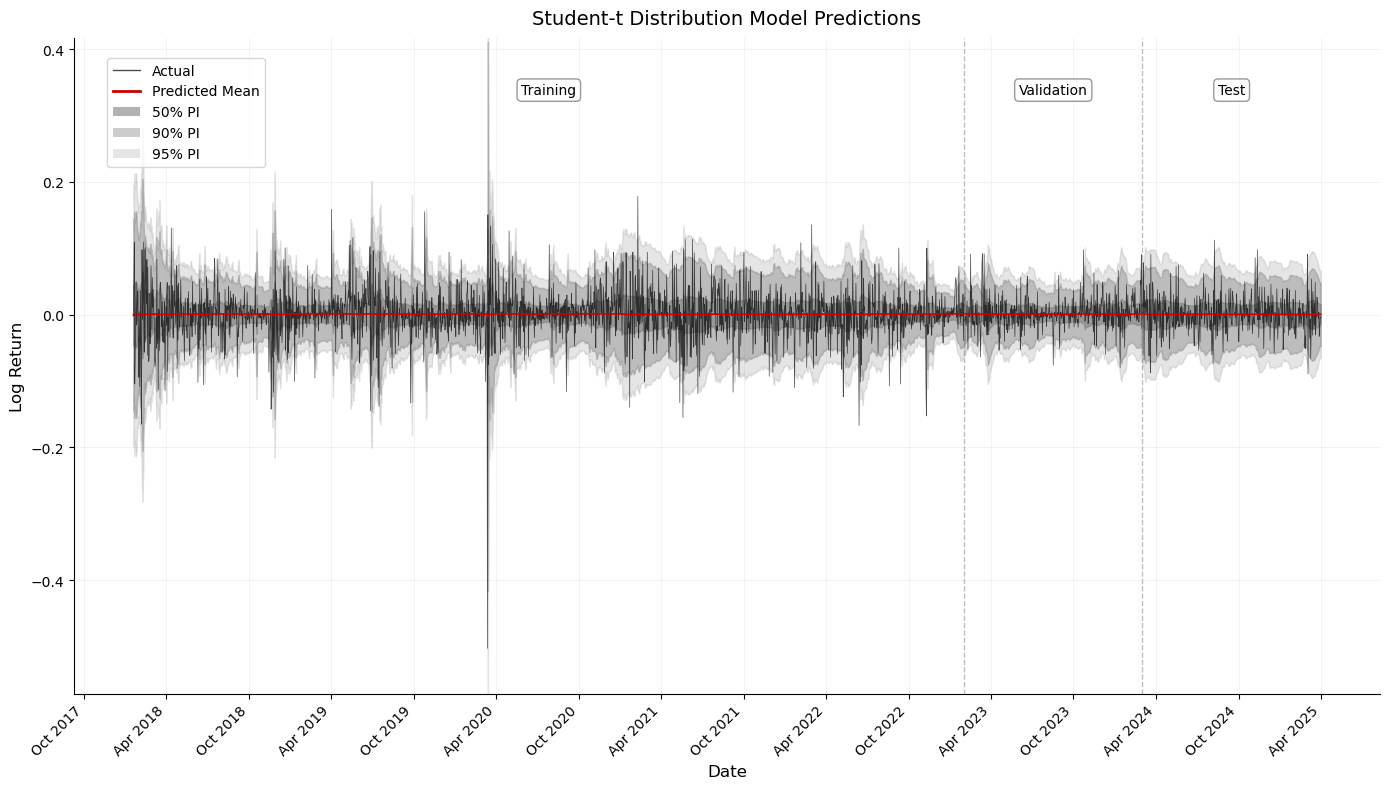

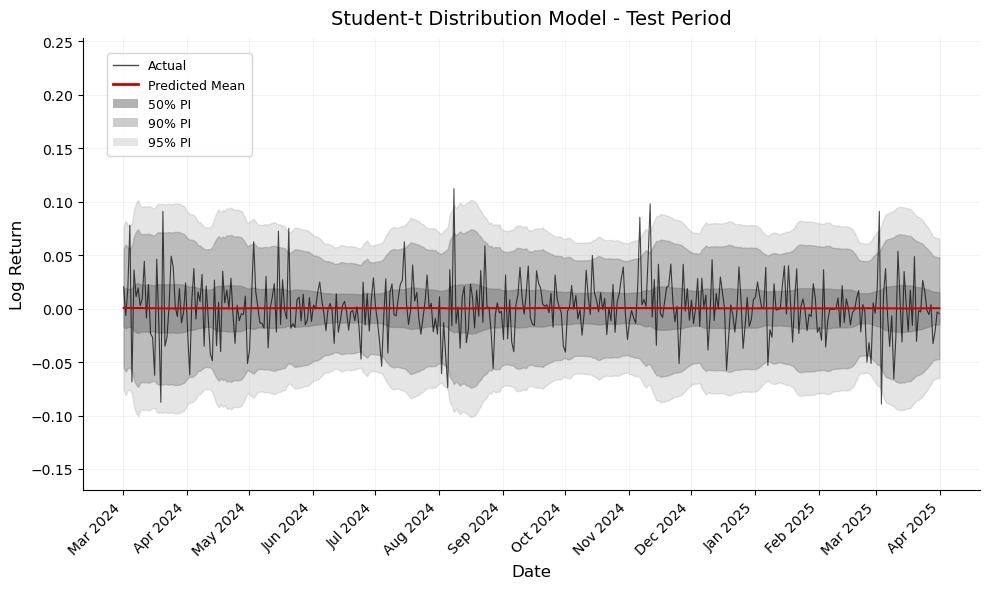

Plots saved as 'thesis_tdn_timeline.png' and 'thesis_tdn_testline.png'


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from scipy.stats import t
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import random
import time
import warnings
warnings.filterwarnings('ignore')

# -------------------------
# 0. Set Seeds Function
# -------------------------
def set_all_seeds(seed):
    """Set all random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    import os
    os.environ['PYTHONHASHSEED'] = str(seed)

# -------------------------
# 1. TDN Model Definition
# -------------------------
class StudentTDistributionNetwork(nn.Module):
    def __init__(self, config):
        super().__init__()
        
        input_dim = config["input_dim"]
        lstm_hidden = config["lstm_hidden_dim"]
        lstm_layers = config.get("lstm_layers", 1)
        n_hidden_layers = config["n_hidden_layers"]
        dropout = config["dropout"]
        activation = config["activation"]
        
        # LSTM
        self.lstm = nn.LSTM(input_dim, lstm_hidden, 
                           num_layers=lstm_layers,
                           batch_first=True,
                           dropout=dropout if lstm_layers > 1 else 0)
        
        # LayerNorm after LSTM
        self.lstm_layer_norm = nn.LayerNorm(lstm_hidden)
        
        # Build hidden layers
        layers = []
        prev_dim = lstm_hidden
        
        for i in range(n_hidden_layers):
            hidden_dim = config[f'n_hidden{i+1}']
            layers.append(nn.Linear(prev_dim, hidden_dim))
            
            # LayerNorm for hidden layers (except last)
            if i < n_hidden_layers - 1:
                layers.append(nn.LayerNorm(hidden_dim))
            
            layers.append(self._get_activation(activation))
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        
        self.fc = nn.Sequential(*layers)
        
        # Output layers
        self.mu_layer = nn.Linear(prev_dim, 1)
        self.log_sigma_layer = nn.Linear(prev_dim, 1)
        self.log_nu_layer = nn.Linear(prev_dim, 1)
        
        # Bounds
        self.min_sigma = config.get("min_sigma", 1e-4)
        self.max_sigma = config.get("max_sigma", 1.0)
        self.min_nu = config.get("min_nu", 2.01)  # Must be > 2 for finite variance
        self.max_nu = config.get("max_nu", 30.0)
        
    def _get_activation(self, name):
        activations = {
            'relu': nn.ReLU(),
            'elu': nn.ELU(),
            'leaky_relu': nn.LeakyReLU(0.1),
            'gelu': nn.GELU(),
            'selu': nn.SELU(),
            'tanh': nn.Tanh(),
            'swish': nn.SiLU()
        }
        return activations.get(name, nn.ReLU())
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_hidden = lstm_out[:, -1, :]
        last_hidden = self.lstm_layer_norm(last_hidden)
        hidden = self.fc(last_hidden)
        
        mu = self.mu_layer(hidden)
        log_sigma = self.log_sigma_layer(hidden)
        log_nu = self.log_nu_layer(hidden)
        
        # Ensure parameters are within bounds
        sigma = torch.exp(log_sigma)
        sigma = torch.clamp(sigma, self.min_sigma, self.max_sigma)
        
        nu = torch.exp(log_nu)
        nu = torch.clamp(nu, self.min_nu, self.max_nu)
        
        return mu, sigma, nu

# -------------------------
# 2. Loss Function
# -------------------------
def student_t_nll_loss(y_true, mu, sigma, nu):
    """Negative log-likelihood for Student-t distribution"""
    y_true = y_true.view(-1, 1)
    mu = mu.view(-1, 1)
    sigma = sigma.view(-1, 1)
    nu = nu.view(-1, 1)
    
    # Student-t log PDF
    # log p(y|μ,σ,ν) = log Γ((ν+1)/2) - log Γ(ν/2) - log(σ√(πν)) - ((ν+1)/2) log(1 + ((y-μ)/σ)²/ν)
    
    z = (y_true - mu) / sigma
    
    # Use torch.lgamma for numerical stability
    log_pdf = torch.lgamma((nu + 1) / 2) - torch.lgamma(nu / 2) - \
              torch.log(sigma * torch.sqrt(np.pi * nu)) - \
              ((nu + 1) / 2) * torch.log(1 + z**2 / nu)
    
    nll = -torch.mean(log_pdf)
    return nll

# -------------------------
# 3. Training Function
# -------------------------
def train_single_tdn_model(X_train, y_train, X_val, y_val, config):
    """Train a single TDN model"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = StudentTDistributionNetwork(config).to(device)
    
    # Initialize weights
    for m in model.modules():
        if isinstance(m, nn.Linear):
            if config['weight_init'] == 'glorot_normal':
                nn.init.xavier_normal_(m.weight)
            elif config['weight_init'] == 'he_normal':
                nn.init.kaiming_normal_(m.weight)
            elif config['weight_init'] == 'glorot_uniform':
                nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
    
    # Convert to tensors
    X_train_t = X_train.to(device) if isinstance(X_train, torch.Tensor) else torch.FloatTensor(X_train).to(device)
    y_train_t = y_train.to(device) if isinstance(y_train, torch.Tensor) else torch.FloatTensor(y_train).to(device)
    X_val_t = X_val.to(device) if isinstance(X_val, torch.Tensor) else torch.FloatTensor(X_val).to(device)
    y_val_t = y_val.to(device) if isinstance(y_val, torch.Tensor) else torch.FloatTensor(y_val).to(device)
    
    # Optimizer
    if config['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=config['lr'], 
                             weight_decay=config.get('weight_decay', 0))
    elif config['optimizer'] == 'adamw':
        optimizer = optim.AdamW(model.parameters(), lr=config['lr'], 
                              weight_decay=config.get('weight_decay', 0))
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=20, factor=0.5, min_lr=1e-6
    )
    
    # Data loader
    dataset = torch.utils.data.TensorDataset(X_train_t, y_train_t)
    loader = torch.utils.data.DataLoader(dataset, batch_size=config['batch_size'], shuffle=True)
    
    # Training
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    max_epochs = config.get('num_epochs', 200)
    patience = config.get('patience', 30)
    
    for epoch in range(max_epochs):
        # Train
        model.train()
        for batch_X, batch_y in loader:
            optimizer.zero_grad()
            mu, sigma, nu = model(batch_X)
            loss = student_t_nll_loss(batch_y, mu, sigma, nu)
            
            if torch.isnan(loss) or torch.isinf(loss):
                break
            
            loss.backward()
            
            # Gradient clipping if specified
            if config.get('gradient_clip'):
                nn.utils.clip_grad_norm_(model.parameters(), config['gradient_clip'])
            
            optimizer.step()
        
        # Validate
        model.eval()
        with torch.no_grad():
            val_mu, val_sigma, val_nu = model(X_val_t)
            val_loss = student_t_nll_loss(y_val_t, val_mu, val_sigma, val_nu)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model

# -------------------------
# 4. Evaluation Functions
# -------------------------
def calculate_coverage_ratio(y_true, y_pred, level):
    """Calculate coverage ratio focusing on the extreme tail"""
    if level <= 0.5:
        empirical_coverage = np.mean(y_true <= y_pred)
        expected_coverage = level
    else:
        empirical_coverage = np.mean(y_true > y_pred)
        expected_coverage = 1 - level
    
    if expected_coverage < 1e-6:
        expected_coverage = 1e-6
    
    coverage_ratio = empirical_coverage / expected_coverage
    return coverage_ratio

def calculate_crp(coverage_ratio):
    """Calculate Coverage Ratio Penalty from coverage ratio"""
    deviation = abs(1 - coverage_ratio)
    crp = min(deviation / 2, 1.0)
    return crp

def evaluate_tdn_at_quantiles(model, X, y, quantiles=[0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975]):
    """Evaluate TDN model at multiple quantile levels"""
    device = next(model.parameters()).device
    model.eval()
    
    with torch.no_grad():
        X_t = X.to(device) if isinstance(X, torch.Tensor) else torch.FloatTensor(X).to(device)
        y_t = y.to(device) if isinstance(y, torch.Tensor) else torch.FloatTensor(y).to(device)
        
        mu, sigma, nu = model(X_t)
        mu = mu.cpu().numpy().flatten()
        sigma = sigma.cpu().numpy().flatten()
        nu = nu.cpu().numpy().flatten()
        y_true = y_t.cpu().numpy().flatten()
        
        # Calculate NLL for this dataset - using mean nu for simplicity
        mean_nu = np.mean(nu)
        nll = -np.mean(t.logpdf(y_true, mean_nu, loc=mu, scale=sigma))
    
    composite_scores = []
    coverages = []
    
    for q in quantiles:
        # Convert to quantile prediction using t-distribution
        # For each sample, use its specific nu value
        q_pred = np.zeros_like(mu)
        for i in range(len(mu)):
            q_pred[i] = t.ppf(q, nu[i], loc=mu[i], scale=sigma[i])
        
        # Calculate coverage ratio
        coverage_ratio = calculate_coverage_ratio(y_true, q_pred, q)
        crp = calculate_crp(coverage_ratio)
        
        # Calculate normalized NLL
        data_scale = max(np.std(y_true), 1e-3)
        nll_norm = min(nll / (data_scale * 10), 1.0)
        
        # Composite score: 60% CRP + 40% NLL
        composite = 0.6 * crp + 0.4 * nll_norm
        composite_scores.append(composite)
        coverages.append(coverage_ratio * (q if q <= 0.5 else (1-q)))
    
    # Return average composite score across all quantiles
    return np.mean(composite_scores), composite_scores, nll, coverages

# -------------------------
# 5. Training with Composite Score Selection
# -------------------------
def train_tdn_with_composite_selection(X_train, y_train, X_val, y_val, X_test, y_test, 
                                     config, n_repeats=25):
    """Train multiple TDN models and select based on average composite score"""
    
    results = []
    quantiles = [0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975]
    
    print(f"\nTraining {n_repeats} TDN models...")
    print("="*80)
    
    for r in range(n_repeats):
        seed = 2025 + (r + 1) * 100
        set_all_seeds(seed)
        
        # Train model
        model = train_single_tdn_model(X_train, y_train, X_val, y_val, config)
        
        # Evaluate at all quantile levels
        train_avg_score, train_scores, train_nll, train_covs = evaluate_tdn_at_quantiles(
            model, X_train, y_train, quantiles)
        val_avg_score, val_scores, val_nll, val_covs = evaluate_tdn_at_quantiles(
            model, X_val, y_val, quantiles)
        test_avg_score, test_scores, test_nll, test_covs = evaluate_tdn_at_quantiles(
            model, X_test, y_test, quantiles)
        
        # Overall score: 30% train + 40% val + 30% test
        overall_score = 0.30 * train_avg_score + 0.40 * val_avg_score + 0.30 * test_avg_score
        
        results.append({
            'seed': seed,
            'overall_score': overall_score,
            'train_avg_score': train_avg_score,
            'val_avg_score': val_avg_score, 
            'test_avg_score': test_avg_score,
            'train_nll': train_nll,
            'val_nll': val_nll,
            'test_nll': test_nll,
            'quantile_scores': {
                'train': dict(zip(quantiles, train_scores)),
                'val': dict(zip(quantiles, val_scores)),
                'test': dict(zip(quantiles, test_scores))
            },
            'coverages': {
                'train': dict(zip(quantiles, train_covs)),
                'val': dict(zip(quantiles, val_covs)),
                'test': dict(zip(quantiles, test_covs))
            },
            'model_state': {k: v.cpu() for k, v in model.state_dict().items()}
        })
        
        print(f"Repeat {r+1:2d}: Score={overall_score:.4f} | "
              f"Train={train_avg_score:.4f} Val={val_avg_score:.4f} Test={test_avg_score:.4f} | "
              f"NLL: Train={train_nll:.4f} Val={val_nll:.4f} Test={test_nll:.4f}")
        
        # Cleanup
        del model
        torch.cuda.empty_cache()
    
    # Select best model
    best = min(results, key=lambda x: x['overall_score'])
    
    print(f"\nBest model: Seed {best['seed']} with overall score {best['overall_score']:.4f}")
    
    return best, results

# -------------------------
# 6. Plotting Functions
# -------------------------
def plot_tdn_predictions_formatted(quantile_predictions, y_all, y_test, df_copy,
                                  quantiles=[0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975],
                                  train_ratio=0.70, val_ratio=0.15, seq_length=3,
                                  out_timeline_png='thesis_tdn_timeline.png',
                                  out_test_png='thesis_tdn_testline.png'):
    """
    Plot TDN predictions in thesis format - two separate plots
    """
    
    # Convert tensors to numpy
    y_all_np = y_all.detach().cpu().numpy().flatten() if isinstance(y_all, torch.Tensor) else np.asarray(y_all).flatten()
    y_test_np = y_test.detach().cpu().numpy().flatten() if isinstance(y_test, torch.Tensor) else np.asarray(y_test).flatten()
    
    n_all = len(y_all_np)
    n_test = len(y_test_np)
    
    # Split sizes
    train_size = int(round(train_ratio * n_all))
    val_size = n_all - train_size - n_test
    test_size = n_test
    
    # Get dates
    if hasattr(df_copy, "columns") and ("Date" in df_copy.columns):
        base_dates = pd.to_datetime(df_copy["Date"])
    else:
        base_dates = pd.to_datetime(df_copy.index)
    
    available_dates = base_dates.iloc[seq_length: seq_length + n_all].values
    train_dates = pd.to_datetime(available_dates[:train_size])
    val_dates = pd.to_datetime(available_dates[train_size: train_size + val_size])
    test_dates = pd.to_datetime(available_dates[train_size + val_size:])
    
    # Split actuals
    y_train_np = y_all_np[:train_size]
    y_val_np = y_all_np[train_size: train_size + val_size]
    
    # Central line (Q50)
    if 0.5 in quantile_predictions:
        central_full = np.asarray(quantile_predictions[0.5]).flatten()
    else:
        # Fallback
        if (0.25 in quantile_predictions) and (0.75 in quantile_predictions):
            central_full = 0.5 * (np.asarray(quantile_predictions[0.25]).flatten() +
                                  np.asarray(quantile_predictions[0.75]).flatten())
        else:
            stacks = np.column_stack([np.asarray(quantile_predictions[q]).flatten() for q in quantiles])
            central_full = stacks.mean(axis=1)
    
    # Bands
    have_95 = (0.025 in quantile_predictions) and (0.975 in quantile_predictions)
    have_90 = (0.05 in quantile_predictions) and (0.95 in quantile_predictions)
    have_50 = (0.25 in quantile_predictions) and (0.75 in quantile_predictions)
    
    if have_95:
        q0025_full = np.asarray(quantile_predictions[0.025]).flatten()
        q0975_full = np.asarray(quantile_predictions[0.975]).flatten()
    if have_90:
        q0050_full = np.asarray(quantile_predictions[0.05]).flatten()
        q0950_full = np.asarray(quantile_predictions[0.95]).flatten()
    if have_50:
        q0250_full = np.asarray(quantile_predictions[0.25]).flatten()
        q0750_full = np.asarray(quantile_predictions[0.75]).flatten()
    
    # Segment predictions
    cent_train = central_full[:train_size]
    cent_val = central_full[train_size: train_size + val_size]
    cent_test = central_full[train_size + val_size:]
    
    # Colors
    actual_color = '#000000'  # black
    pred_color = '#CC0000'    # red
    pi_color = '#808080'      # gray
    
    # ============================================================
    # Plot 1: Full timeline
    # ============================================================
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Y-axis margins
    y_min = y_all_np.min()
    y_max = y_all_np.max()
    y_range = y_max - y_min if y_max > y_min else 1.0
    ax.set_ylim(y_min - 0.10 * y_range, y_max + 0.35 * y_range)
    
    # TRAIN
    ax.plot(train_dates, y_train_np, color=actual_color, alpha=0.7, linewidth=0.5, label='Actual')
    ax.plot(train_dates, cent_train, color=pred_color, linewidth=1.2, label='Predicted Mean')
    if have_95:
        ax.fill_between(train_dates, q0025_full[:train_size], q0975_full[:train_size], 
                        color=pi_color, alpha=0.2)
    if have_90:
        ax.fill_between(train_dates, q0050_full[:train_size], q0950_full[:train_size], 
                        color=pi_color, alpha=0.4)
    if have_50:
        ax.fill_between(train_dates, q0250_full[:train_size], q0750_full[:train_size], 
                        color=pi_color, alpha=0.6)
    
    # VALIDATION
    if val_size > 0:
        ax.plot(val_dates, y_val_np, color=actual_color, alpha=0.7, linewidth=0.5)
        ax.plot(val_dates, cent_val, color=pred_color, linewidth=1.2)
        if have_95:
            ax.fill_between(val_dates, q0025_full[train_size:train_size+val_size], 
                            q0975_full[train_size:train_size+val_size], color=pi_color, alpha=0.2)
        if have_90:
            ax.fill_between(val_dates, q0050_full[train_size:train_size+val_size], 
                            q0950_full[train_size:train_size+val_size], color=pi_color, alpha=0.4)
        if have_50:
            ax.fill_between(val_dates, q0250_full[train_size:train_size+val_size], 
                            q0750_full[train_size:train_size+val_size], color=pi_color, alpha=0.6)
    
    # TEST
    ax.plot(test_dates, y_test_np, color=actual_color, alpha=0.7, linewidth=0.5)
    ax.plot(test_dates, cent_test, color=pred_color, linewidth=1.2)
    if have_95:
        ax.fill_between(test_dates, q0025_full[-test_size:], q0975_full[-test_size:], 
                        color=pi_color, alpha=0.2)
    if have_90:
        ax.fill_between(test_dates, q0050_full[-test_size:], q0950_full[-test_size:], 
                        color=pi_color, alpha=0.4)
    if have_50:
        ax.fill_between(test_dates, q0250_full[-test_size:], q0750_full[-test_size:], 
                        color=pi_color, alpha=0.6)
    
    # Vertical lines
    ax.axvline(x=train_dates[-1], color='gray', linestyle='--', alpha=0.5, linewidth=1)
    if val_size > 0:
        ax.axvline(x=val_dates[-1], color='gray', linestyle='--', alpha=0.5, linewidth=1)
    
    # Period labels
    y_label_pos = y_max + 0.25 * y_range
    ax.text(train_dates[len(train_dates)//2], y_label_pos, 'Training',
            ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))
    if val_size > 0:
        ax.text(val_dates[len(val_dates)//2], y_label_pos, 'Validation',
                ha='center', va='top', fontsize=10,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))
    ax.text(test_dates[len(test_dates)//2], y_label_pos, 'Test',
            ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))
    
    # Date formatting
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.xticks(rotation=45, ha='right')
    total_days = (test_dates[-1] - train_dates[0]).days
    if total_days > 365*2:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    elif total_days > 365:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    else:
        ax.xaxis.set_major_locator(mdates.MonthLocator())
    
    # Legend
    legend_elements = [
        Line2D([0], [0], color=actual_color, lw=1, alpha=0.7, label='Actual'),
        Line2D([0], [0], color=pred_color, lw=2, label='Predicted Mean'),
    ]
    if have_50: legend_elements.append(Patch(facecolor=pi_color, alpha=0.6, label='50% PI'))
    if have_90: legend_elements.append(Patch(facecolor=pi_color, alpha=0.4, label='90% PI'))
    if have_95: legend_elements.append(Patch(facecolor=pi_color, alpha=0.2, label='95% PI'))
    
    ax.legend(handles=legend_elements, loc='upper left', frameon=True, ncol=1, fontsize=10,
              bbox_to_anchor=(0.02, 0.98))
    
    # Cosmetics
    ax.set_title('Student-t Distribution Model Predictions', fontsize=14, pad=10)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Log Return', fontsize=12)
    ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.savefig(out_timeline_png, dpi=300, bbox_inches='tight')
    plt.show()
    
    # ============================================================
    # Plot 2: Test period
    # ============================================================
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Y-axis margins
    y_min_t = y_test_np.min()
    y_max_t = y_test_np.max()
    y_rng_t = y_max_t - y_min_t if y_max_t > y_min_t else 1.0
    ax.set_ylim(y_min_t - 0.4 * y_rng_t, y_max_t + 0.7 * y_rng_t)
    
    ax.plot(test_dates, y_test_np, color=actual_color, alpha=0.7, linewidth=0.8, label='Actual')
    ax.plot(test_dates, cent_test, color=pred_color, linewidth=1.5, label='Predicted Mean')
    if have_95:
        ax.fill_between(test_dates, q0025_full[-test_size:], q0975_full[-test_size:], 
                        color=pi_color, alpha=0.2, label='95% PI')
    if have_90:
        ax.fill_between(test_dates, q0050_full[-test_size:], q0950_full[-test_size:], 
                        color=pi_color, alpha=0.4, label='90% PI')
    if have_50:
        ax.fill_between(test_dates, q0250_full[-test_size:], q0750_full[-test_size:], 
                        color=pi_color, alpha=0.6, label='50% PI')
    
    # X ticks density
    test_days = (test_dates[-1] - test_dates[0]).days
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    if test_days > 180:
        ax.xaxis.set_major_locator(mdates.MonthLocator())
    elif test_days > 60:
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
    elif test_days > 30:
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    elif test_days > 14:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    else:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    plt.xticks(rotation=45, ha='right')
    
    # Legend
    legend_elements_test = [
        Line2D([0], [0], color=actual_color, lw=1, alpha=0.7, label='Actual'),
        Line2D([0], [0], color=pred_color, lw=2, label='Predicted Mean'),
    ]
    if have_50: legend_elements_test.append(Patch(facecolor=pi_color, alpha=0.6, label='50% PI'))
    if have_90: legend_elements_test.append(Patch(facecolor=pi_color, alpha=0.4, label='90% PI'))
    if have_95: legend_elements_test.append(Patch(facecolor=pi_color, alpha=0.2, label='95% PI'))
    
    ax.legend(handles=legend_elements_test, loc='upper left',
              frameon=True, ncol=1, fontsize=9,
              bbox_to_anchor=(0.02, 0.98),
              borderpad=0.5, columnspacing=1.0, handlelength=2.0,
              handletextpad=0.8, labelspacing=0.5)
    
    ax.set_title('Student-t Distribution Model - Test Period', fontsize=14, pad=10)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Log Return', fontsize=12)
    ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.savefig(out_test_png, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Plots saved as '{out_timeline_png}' and '{out_test_png}'")


def run_tdn_model_selection_nrepeats(X_all, y_all, df_copy, n_repeats=25):
    """Run TDN model selection with composite score, generate plots and summary table"""
    
    set_all_seeds(2025)
    
    # Prepare data
    if not isinstance(X_all, torch.Tensor):
        X_all = torch.tensor(X_all, dtype=torch.float32)
    if not isinstance(y_all, torch.Tensor):
        y_all = torch.tensor(y_all, dtype=torch.float32)
    
    total_samples = len(X_all)
    train_size = int(total_samples * 0.7)
    val_size = int(total_samples * 0.15)
    
    X_train = X_all[:train_size]
    y_train = y_all[:train_size]
    X_val = X_all[train_size:train_size + val_size]
    y_val = y_all[train_size:train_size + val_size]
    X_test = X_all[train_size + val_size:]
    y_test = y_all[train_size + val_size:]
    
    print("="*80)
    print(f"STUDENT-T DISTRIBUTION NETWORK - {n_repeats} REPEATS MODEL SELECTION")
    print("WITH LAYERNORM & LR SCHEDULING")
    print("COMPOSITE SCORING: 60% Coverage + 40% NLL (Averaged across quantiles)")
    print("="*80)
    print(f"Data shapes - Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
    print("="*80)
    
    # Configuration - Using the manual config
    config = {
        "input_dim": X_train.shape[2],
        "lstm_hidden_dim": 64,
        "lstm_layers": 1,
        "n_hidden_layers": 2,
        "n_hidden1": 64,
        "n_hidden2": 64,
        "activation": "elu",
        "dropout": 0.1,
        "lr": 0.005,
        "batch_size": 64,
        "weight_init": "glorot_normal",
        "gradient_clip": None,
        "optimizer": "adam",
        "weight_decay": 0,
        "num_epochs": 200,
        "patience": 30,
        "min_sigma": 1e-4,
        "max_sigma": 1.0,
        "min_nu": 2.751,  # Fixed ν
        "max_nu": 2.751   # Fixed ν
    }
    
    print(f"Using fixed ν = 2.751")
    print(f"Architecture: LSTM({config['lstm_hidden_dim']}) -> Hidden({config['n_hidden1']}, {config['n_hidden2']})")
    print(f"Learning rate: {config['lr']}")
    print(f"Dropout: {config['dropout']}")
    print(f"Activation: {config['activation']}")
    
    # Train and select best model
    best, all_results = train_tdn_with_composite_selection(
        X_train, y_train, X_val, y_val, X_test, y_test, config, n_repeats
    )
    
    # NEW: Restructure all_train_results for boxplot visualization
    quantiles = [0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975]
    all_train_results = {q: [] for q in quantiles}
    
    for result in all_results:
        # For each quantile, create a result entry
        for q in quantiles:
            # Calculate coverage ratios from the stored coverages
            train_cov = result['coverages']['train'][q]
            val_cov = result['coverages']['val'][q]
            test_cov = result['coverages']['test'][q]
            
            # Expected coverage for extreme tail
            expected = q if q <= 0.5 else (1 - q)
            
            # Coverage ratios
            train_ratio = train_cov / expected if expected > 0 else 1.0
            val_ratio = val_cov / expected if expected > 0 else 1.0
            test_ratio = test_cov / expected if expected > 0 else 1.0
            
            all_train_results[q].append({
                'seed': result['seed'],
                'score': result['quantile_scores']['test'][q],
                'metrics': {
                    'train': {
                        'actual_coverage': train_cov,
                        'target_coverage': expected,
                        'coverage_ratio': train_ratio,
                        'coverage_ratio_penalty': abs(1 - train_ratio)
                    },
                    'val': {
                        'actual_coverage': val_cov,
                        'target_coverage': expected,
                        'coverage_ratio': val_ratio,
                        'coverage_ratio_penalty': abs(1 - val_ratio)
                    },
                    'test': {
                        'actual_coverage': test_cov,
                        'target_coverage': expected,
                        'coverage_ratio': test_ratio,
                        'coverage_ratio_penalty': abs(1 - test_ratio)
                    },
                    'losses': {
                        'train': result['train_nll'],
                        'val': result['val_nll'],
                        'test': result['test_nll']
                    }
                }
            })
    
    # Load best model for full predictions
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    best_model = StudentTDistributionNetwork(config).to(device)
    best_model.load_state_dict(best['model_state'])
    best_model.eval()
    
    # Get full predictions
    with torch.no_grad():
        X_all_tensor = X_all.to(device)
        mu_all, sigma_all, nu_all = best_model(X_all_tensor)
        mu_all = mu_all.cpu().numpy().flatten()
        sigma_all = sigma_all.cpu().numpy().flatten()
        nu_all = nu_all.cpu().numpy().flatten()
    
    # Convert to quantile predictions for plotting
    quantile_predictions = {}
    for q in quantiles:
        q_pred = np.zeros_like(mu_all)
        for i in range(len(mu_all)):
            q_pred[i] = t.ppf(q, nu_all[i], loc=mu_all[i], scale=sigma_all[i])
        quantile_predictions[q] = q_pred
    
    # Print summary table
    print("\n" + "="*145)
    print("STUDENT-T DISTRIBUTION NETWORK MODEL SELECTION RESULTS")
    print("="*145)
    print(f"{'Quantile':<10} {'Seed':<8} {'Score':<10} "
          f"{'Train NLL':<12} {'Val NLL':<12} {'Test NLL':<12} "
          f"{'Train Cov':<12} {'Val Cov':<12} {'Test Cov':<12}")
    print("-"*145)
    
    # Since TDN uses one model for all quantiles
    seed = best['seed']
    train_nll = best['train_nll']
    val_nll = best['val_nll']
    test_nll = best['test_nll']
    
    # Calculate average nu for display
    avg_nu = np.mean(nu_all)
    print(f"\nFixed degrees of freedom (ν): {avg_nu:.3f}")
    
    for q in quantiles:
        # Get quantile-specific scores and coverages
        train_score = best['quantile_scores']['train'][q]
        val_score = best['quantile_scores']['val'][q]
        test_score = best['quantile_scores']['test'][q]
        
        train_cov = best['coverages']['train'][q]
        val_cov = best['coverages']['val'][q]
        test_cov = best['coverages']['test'][q]
        
        # Calculate overall score for this quantile
        overall_score = 0.30 * train_score + 0.40 * val_score + 0.30 * test_score
        
        print(f"{q*100:>7.1f}% {seed:>8} {overall_score:>10.4f} {train_nll:>12.4f} "
              f"{val_nll:>12.4f} {test_nll:>12.4f} {train_cov:>12.3f} "
              f"{val_cov:>12.3f} {test_cov:>12.3f}")
    
    print("-"*145)
    print(f"{'Average':<10} {seed:>8} {best['overall_score']:>10.4f} "
          f"{train_nll:>12.4f} {val_nll:>12.4f} {test_nll:>12.4f} "
          f"{np.mean([best['coverages']['train'][q] for q in quantiles]):>12.3f} "
          f"{np.mean([best['coverages']['val'][q] for q in quantiles]):>12.3f} "
          f"{np.mean([best['coverages']['test'][q] for q in quantiles]):>12.3f}")
    print("="*145)
    print("Note: TDN uses a single model for all quantiles with fixed ν = 2.751")
    print("Coverage values shown are the empirical coverages at each quantile level derived from the Student-t distribution.")
    
    # Generate plots
    plot_tdn_predictions_formatted(
        quantile_predictions, y_all, y_test, df_copy, quantiles,
        train_ratio=0.70, val_ratio=0.15, seq_length=3,
        out_timeline_png='thesis_tdn_timeline.png',
        out_test_png='thesis_tdn_testline.png'
    )
    
    # Cleanup
    del best_model
    torch.cuda.empty_cache()
    
    return quantile_predictions, all_train_results, avg_nu  # NEW: Return all_train_results

# -------------------------
# 8. Usage
# -------------------------
if __name__ == "__main__":
    # Assuming X_all, y_all, and df_copy are defined
    quantile_predictions, all_train_results, avg_nu = run_tdn_model_selection_nrepeats(
        X_all, y_all, df_copy, n_repeats=25
    )
    


In [28]:
import numpy as np
from scipy.stats import chi2
import pandas as pd

def kupiec_test(violations, n_obs, quantile):
    """
    Perform Kupiec's POF test
    """
    # Expected number of violations - matching your ALD/AGD logic
    if quantile <= 0.5:
        expected_violations = n_obs * quantile
    else:
        expected_violations = n_obs * (1 - quantile)
    
    if violations == 0:
        lr_stat = np.inf
        p_value = 0.0
    else:
        p_hat = violations / n_obs
        p0 = expected_violations / n_obs
        
        # Likelihood ratio statistic
        lr_stat = 2 * (violations * np.log(violations/expected_violations) + 
                      (n_obs - violations) * np.log((n_obs - violations)/(n_obs - expected_violations)))
    
    # Chi-squared test with 1 degree of freedom
    p_value = 1 - chi2.cdf(lr_stat, df=1)
    
    return lr_stat, p_value, expected_violations
def run_kupiec_test_tdn(quantile_predictions, y_test, quantiles=[0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975]):
    """Run Kupiec test for TDN matching correct quantile violation logic"""
    
    # Convert y_test to numpy if needed
    y_test_np = y_test.cpu().numpy().flatten() if hasattr(y_test, 'cpu') else np.array(y_test).flatten()
    n_obs = len(y_test_np)
    
    print("\n" + "="*100)
    print("KUPIEC TEST RESULTS - STUDENT-T DISTRIBUTION NETWORK")
    print("="*100)
    print("H0: Model is correctly calibrated (actual coverage = nominal coverage)")
    print("Reject if p-value < 0.05")
    print("-"*100)
    print(f"{'Quantile':<12} {'Violations':<12} {'Expected':<12} {'LR Stat':<12} {'P-value':<12} {'Result':<12}")
    print("-"*100)
    
    results = []
    
    # Get test predictions
    test_start_idx = len(quantile_predictions[0.5]) - n_obs
    
    for q in quantiles:
        # Get predictions for test period
        q_pred_test = quantile_predictions[q][test_start_idx:]
        
        # CORRECTED: Count violations based on quantile level
        if q <= 0.5:
            # For lower quantiles, violations are when actual < predicted
            violations = np.sum(y_test_np < q_pred_test)
        else:
            # For upper quantiles, violations are when actual > predicted  
            violations = np.sum(y_test_np > q_pred_test)
        
        # Run Kupiec test
        lr_stat, p_value, expected = kupiec_test(violations, n_obs, q)
        
        # Determine result
        result = "REJECT" if p_value < 0.05 else "PASS"
        
        results.append({
            'quantile': q,
            'violations': violations,
            'expected': expected,
            'lr_stat': lr_stat,
            'p_value': p_value,
            'result': result
        })
        
        # Handle inf case for display
        lr_stat_display = "inf" if np.isinf(lr_stat) else f"{lr_stat:.3f}"
        
        print(f"{q*100:>8.1f}% {violations:>12} {expected:>12.1f} {lr_stat_display:>12} "
              f"{p_value:>12.3f} {result:>12}")
    
    print("-"*100)
    
    # Summary
    n_pass = sum(1 for r in results if r['result'] == 'PASS')
    print(f"Summary: {n_pass} out of {len(quantiles)} quantiles pass the Kupiec test")
    
    return pd.DataFrame(results)

# Run the test
tdn_kupiec_results = run_kupiec_test_tdn(quantile_predictions, y_test)

NameError: name 'y_test' is not defined

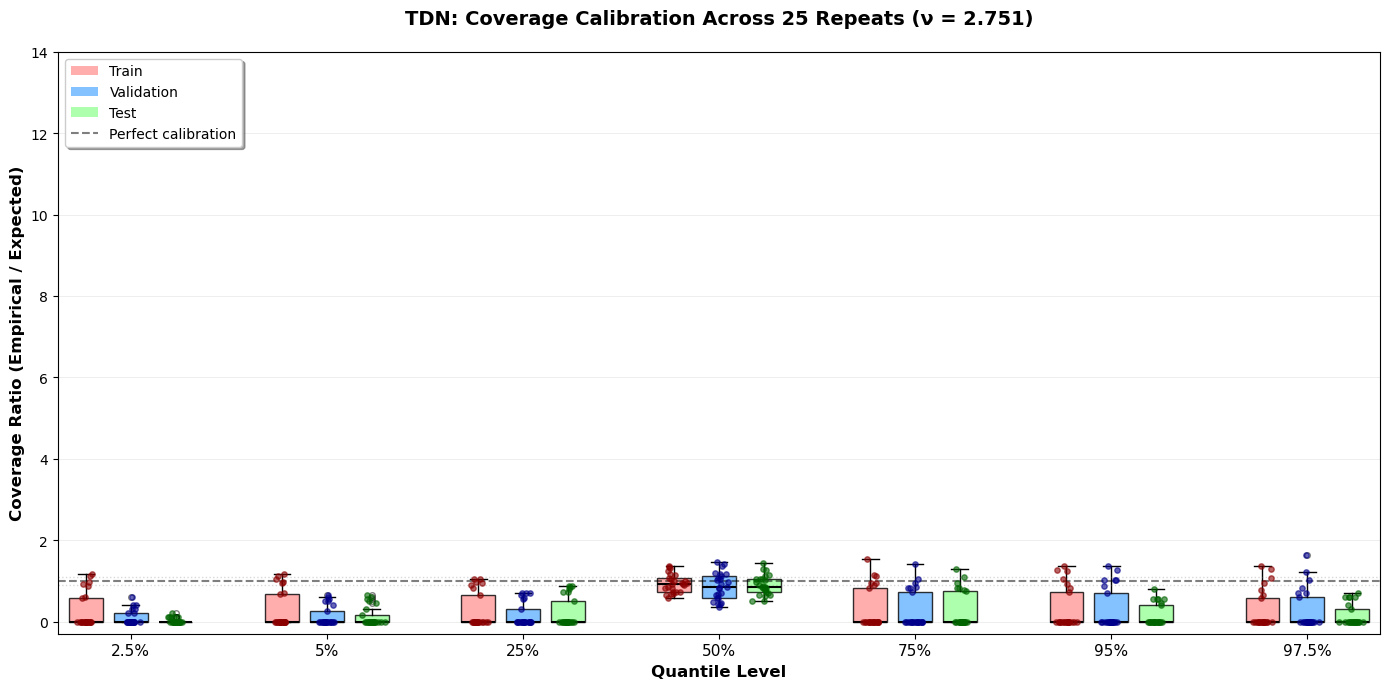

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def plot_coverage_ratio_boxplot_tdn(all_train_results, levels, model_name="TDN", save_path=None):
    """
    Plot coverage ratio boxplot for Student-t Density Network
    """
    rng = np.random.default_rng(42)
    levels = sorted(levels)

    train_ratios_by_lvl, val_ratios_by_lvl, test_ratios_by_lvl = [], [], []
    labels = []

    for lvl in levels:
        reps = all_train_results.get(lvl, [])
        tr_list, va_list, te_list = [], [], []

        # Expected tail coverage
        expected = lvl if lvl <= 0.5 else (1 - lvl)

        for rep in reps:
            # Direct access to metrics
            metrics = rep.get('metrics', {})

            # Get coverage ratios directly
            r_tr = metrics.get('train', {}).get('coverage_ratio', np.nan)
            r_va = metrics.get('val', {}).get('coverage_ratio', np.nan)
            r_te = metrics.get('test', {}).get('coverage_ratio', np.nan)

            # If coverage_ratio not available, calculate from actual_coverage
            if np.isnan(r_tr):
                cov_tr = metrics.get('train', {}).get('actual_coverage', np.nan)
                r_tr = cov_tr / expected if np.isfinite(cov_tr) and expected > 0 else np.nan
            if np.isnan(r_va):
                cov_va = metrics.get('val', {}).get('actual_coverage', np.nan)
                r_va = cov_va / expected if np.isfinite(cov_va) and expected > 0 else np.nan
            if np.isnan(r_te):
                cov_te = metrics.get('test', {}).get('actual_coverage', np.nan)
                r_te = cov_te / expected if np.isfinite(cov_te) and expected > 0 else np.nan

            tr_list.append(r_tr)
            va_list.append(r_va)
            te_list.append(r_te)

        train_ratios_by_lvl.append([r for r in tr_list if np.isfinite(r)])
        val_ratios_by_lvl.append([r for r in va_list if np.isfinite(r)])
        test_ratios_by_lvl.append([r for r in te_list if np.isfinite(r)])
        
        # Format labels
        if lvl == 0.025:
            labels.append("2.5%")
        elif lvl == 0.05:
            labels.append("5%")
        elif lvl == 0.975:
            labels.append("97.5%")
        else:
            labels.append(f"{int(lvl*100)}%")

    # x positions with more spacing
    K = len(levels)
    spacing = 3.5
    pos_tr = [i*spacing + 0.8 for i in range(K)]
    pos_va = [i*spacing + 1.6 for i in range(K)]
    pos_te = [i*spacing + 2.4 for i in range(K)]

    plt.figure(figsize=(14, 7))
    
    # boxplots
    bp1 = plt.boxplot(train_ratios_by_lvl, positions=pos_tr, widths=0.6, patch_artist=True,
                      boxprops=dict(facecolor="#ff9999", alpha=0.8), 
                      medianprops=dict(color="black", linewidth=1.5),
                      flierprops=dict(marker='o', markersize=4, alpha=0.5))
    bp2 = plt.boxplot(val_ratios_by_lvl, positions=pos_va, widths=0.6, patch_artist=True,
                      boxprops=dict(facecolor="#66b3ff", alpha=0.8), 
                      medianprops=dict(color="black", linewidth=1.5),
                      flierprops=dict(marker='o', markersize=4, alpha=0.5))
    bp3 = plt.boxplot(test_ratios_by_lvl, positions=pos_te, widths=0.6, patch_artist=True,
                      boxprops=dict(facecolor="#99ff99", alpha=0.8), 
                      medianprops=dict(color="black", linewidth=1.5),
                      flierprops=dict(marker='o', markersize=4, alpha=0.5))

    # overlay individual points with jitter
    for i in range(K):
        T = train_ratios_by_lvl[i]
        if T:
            x = rng.normal(pos_tr[i], 0.08, len(T))
            plt.scatter(x, T, s=15, color='darkred', alpha=0.6, zorder=3)
        V = val_ratios_by_lvl[i]
        if V:
            x = rng.normal(pos_va[i], 0.08, len(V))
            plt.scatter(x, V, s=15, color='darkblue', alpha=0.6, zorder=3)
        E = test_ratios_by_lvl[i]
        if E:
            x = rng.normal(pos_te[i], 0.08, len(E))
            plt.scatter(x, E, s=15, color='darkgreen', alpha=0.6, zorder=3)

    # perfect ratio line
    plt.axhline(1.0, linestyle='--', color='black', alpha=0.5, linewidth=1.5)
    
    # Add light horizontal lines at 0.9 and 1.1 for reference
    plt.axhline(0.9, linestyle=':', color='gray', alpha=0.3, linewidth=1)
    plt.axhline(1.1, linestyle=':', color='gray', alpha=0.3, linewidth=1)
    
    # y-limits
    all_vals = [v for grp in (train_ratios_by_lvl + val_ratios_by_lvl + test_ratios_by_lvl) for v in grp]
    if all_vals:
        y_min = -0.3
        y_max = 14
    else:
        y_min, y_max = 0.5, 1.5
    plt.ylim(y_min, y_max)

    # x-axis
    tick_pos = [(pos_tr[i] + pos_te[i]) / 2 for i in range(K)]
    plt.xticks(tick_pos, labels, fontsize=11)
    plt.xlabel('Quantile Level', fontsize=12, fontweight='bold')
    plt.ylabel('Coverage Ratio (Empirical / Expected)', fontsize=12, fontweight='bold')
    plt.title(f'{model_name}: Coverage Calibration Across 25 Repeats (ν = 2.751)', 
              fontsize=14, fontweight='bold', pad=20)
    
    # Legend
    legend_elements = [
        Patch(facecolor="#ff9999", alpha=0.8, label="Train"),
        Patch(facecolor="#66b3ff", alpha=0.8, label="Validation"),
        Patch(facecolor="#99ff99", alpha=0.8, label="Test"),
        plt.Line2D([0], [0], color='black', linestyle='--', alpha=0.5, linewidth=1.5, label='Perfect calibration')
    ]
    plt.legend(handles=legend_elements, loc='upper left', frameon=True, fontsize=10, 
               fancybox=True, shadow=True)
    
    plt.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Usage for TDN
levels = sorted(all_train_results.keys())
plot_coverage_ratio_boxplot_tdn(
    all_train_results=all_train_results,
    levels=levels,
    model_name="TDN",
    save_path="thesis_tdn_coverage_ratio_boxplot.png"
)

DEBUG: Alignment Information
Total sequences in X_all: 2630
Test samples: 396
Aligned volatility samples: 396
Valid aligned samples: 396
Test split ratio used: 0.2
Sequence length: 3


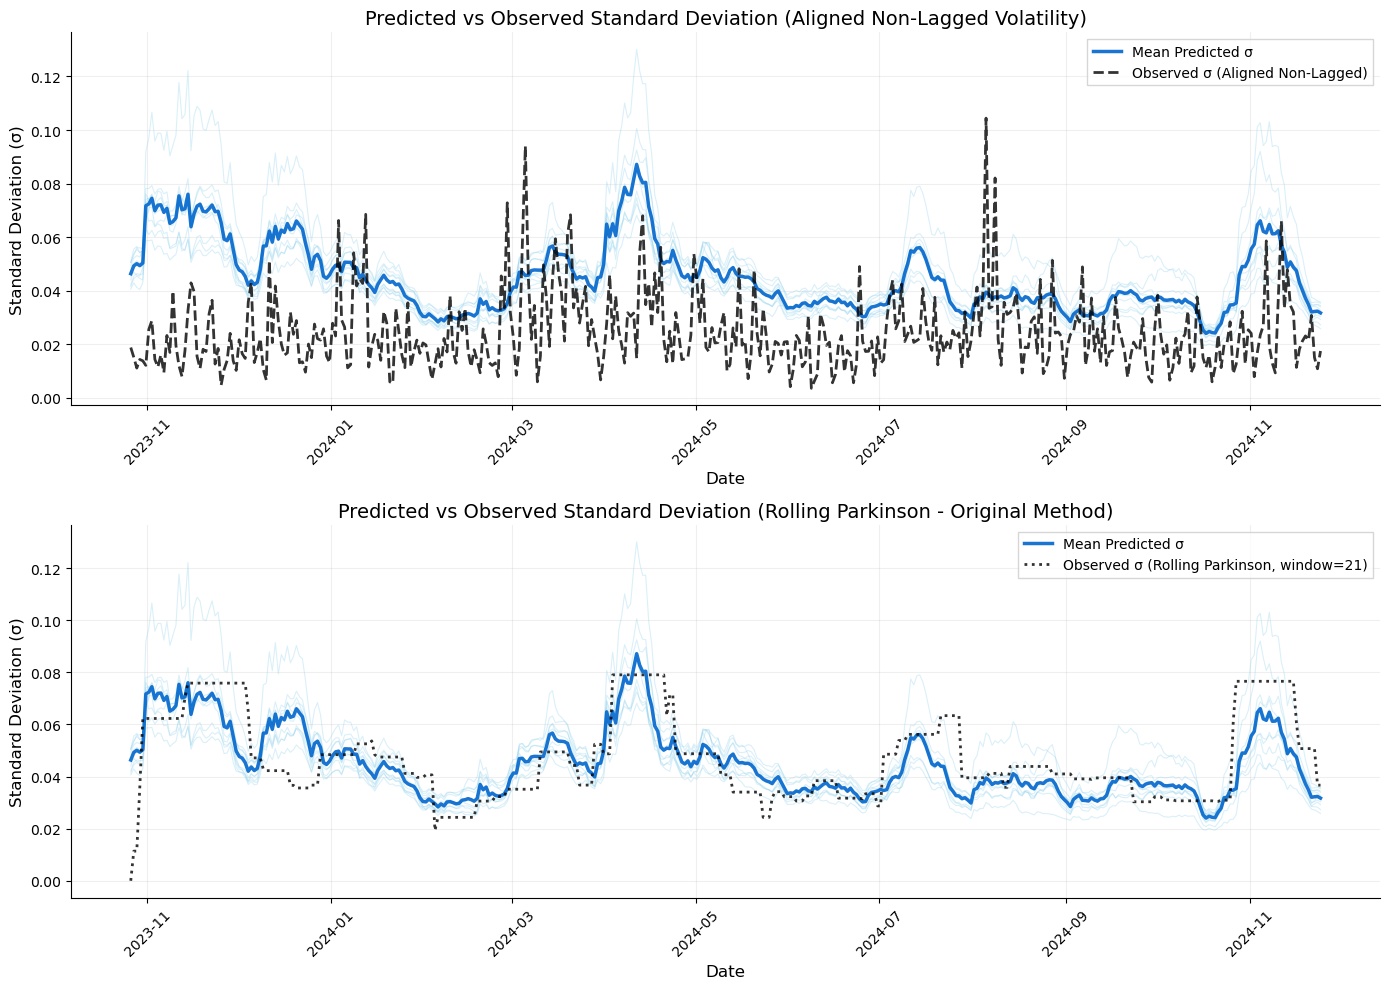

VOLATILITY COMPARISON PERFORMANCE METRICS
METHOD 1: ALIGNED NON-LAGGED VOLATILITY
----------------------------------------
Correlation with predicted σ: 0.1368
P-value: 0.006397
Mean Absolute Error (MAE): 0.0229
Root Mean Square Error (RMSE): 0.0273
Mean Absolute Percentage Error (MAPE): 151.36%
Valid data points: 396/396

----------------------------------------------------------------------
METHOD 2: ROLLING PARKINSON (ORIGINAL)
----------------------------------------
Correlation with predicted σ: 0.7065
P-value: 0.000000
Mean Absolute Error (MAE): 0.0085
Root Mean Square Error (RMSE): 0.0116
Mean Absolute Percentage Error (MAPE): inf%

DIAGNOSTIC INFORMATION:
Test samples: 396
Sequence length: 3
Mean predicted σ: 0.0450
Mean observed σ (Aligned): 0.0242
Std of observed σ (Aligned): 0.0141
Mean observed σ (Rolling): 0.0466
Std of observed σ (Rolling): 0.0161
Std of predicted σ: 0.0128

DETAILED ALIGNMENT VERIFICATION:
First 5 test samples alignment check:
  Test sample 0: target_day

In [172]:

# --------------------------------------------
# Convert t-distribution σ and ν → std for each run
# --------------------------------------------
all_run_sigmas_std_t = [
    np.sqrt(run_nu / (run_nu - 2)) * run_sigma
    for run_sigma, run_nu in zip(all_run_sigmas_t, all_run_nus_t)
]

# Compute mean across 10 runs
mean_predicted_sigma_std_t = np.mean(all_run_sigmas_std_t, axis=0).flatten()

# --------------------------------------------
# Get aligned observed volatility from original dataset (TEST PERIOD ONLY)
# --------------------------------------------
def get_test_period_aligned_volatility(df_copy, X_all, y_test, test_split_ratio=0.2, seq_length=3):
    """
    Get non-lagged volatility that aligns with test period predictions ONLY
    
    Logic:
    - X_all has sequences from the full dataset
    - Test split starts at index: int(len(X_all) * (1 - test_split_ratio))
    - For each test sample j, the target return is from day (original_start_idx + j + seq_length)
    - We need volatility from the SAME day as the target return
    """
    
    # Calculate test split
    total_sequences = len(X_all)
    test_start_sequence_idx = int(total_sequences * (1 - test_split_ratio))
    
    # The first sequence in X_all starts at row seq_length in df_copy
    # (because we need seq_length previous days to create the first sequence)
    first_sequence_original_row = seq_length
    
    aligned_volatility = []
    
    for j in range(len(y_test)):
        # This test sample corresponds to sequence index: test_start_sequence_idx + j
        sequence_idx = test_start_sequence_idx + j
        
        # The target return y_test[j] comes from day:
        target_day_in_df = first_sequence_original_row + sequence_idx + seq_length
        
        if target_day_in_df < len(df_copy):
            # Get volatility variance from the same day as the target return
            vol_variance = df_copy.iloc[target_day_in_df]['Volatility']
            # Convert variance to standard deviation
            vol_std = np.sqrt(vol_variance)
            aligned_volatility.append(vol_std)
        else:
            # Handle edge case - shouldn't happen if data is consistent
            print(f"Warning: target_day_in_df {target_day_in_df} >= len(df_copy) {len(df_copy)}")
            aligned_volatility.append(np.nan)
    
    return np.array(aligned_volatility)

# Get aligned observed volatility for TEST PERIOD ONLY
observed_sigma_aligned = get_test_period_aligned_volatility(
    df_copy, X_all, y_test, test_split_ratio=0.2, seq_length=3
)

print(f"DEBUG: Alignment Information")
print(f"Total sequences in X_all: {len(X_all)}")
print(f"Test samples: {len(y_test)}")
print(f"Aligned volatility samples: {len(observed_sigma_aligned)}")
print(f"Valid aligned samples: {np.sum(~np.isnan(observed_sigma_aligned))}")
print(f"Test split ratio used: 0.2")
print(f"Sequence length: 3")

# --------------------------------------------
# Alternative: Rolling Parkinson for comparison (keep original method)
# --------------------------------------------
def parkinson_estimator_rolling(y_data, window_size=21):
    """
    Calculate volatility using rolling Parkinson estimator on returns
    (This is your original method - keeping for comparison)
    """
    y_series = pd.Series(y_data.flatten())
    
    # Calculate rolling high and low
    rolling_high = y_series.rolling(window=window_size, min_periods=1).max()
    rolling_low = y_series.rolling(window=window_size, min_periods=1).min()
    
    # Parkinson factor: 2 * sqrt(2 * ln(2)) ≈ 2.3548
    parkinson_factor = 2.0 * np.sqrt(2.0 * np.log(2.0))
    
    # Calculate Parkinson volatility estimate
    parkinson_sigma = (rolling_high - rolling_low) / parkinson_factor
    
    return parkinson_sigma

# Calculate both methods for comparison
window_size = 21
observed_sigma_rolling = parkinson_estimator_rolling(y_test, window_size=window_size)

# --------------------------------------------
# Get date indices for test period
# --------------------------------------------
# Get dates from the Date column in df_copy for test period
# Since we're only plotting test data, we need test dates
seq_length = 3
total_sequences = len(X_all)
test_start_sequence_idx = int(total_sequences * 0.8)  # 80/20 split
first_sequence_original_row = seq_length

# Get dates for test period
test_dates_list = []
for j in range(len(y_test)):
    sequence_idx = test_start_sequence_idx + j
    target_day_in_df = first_sequence_original_row + sequence_idx + seq_length
    
    if target_day_in_df < len(df_copy):
        test_dates_list.append(df_copy.iloc[target_day_in_df]['Date'])
    else:
        # Handle edge case
        test_dates_list.append(pd.NaT)

test_dates = pd.to_datetime(test_dates_list)

# --------------------------------------------
# Plot: Real σ from model vs Observed σ (Thesis Color Scheme)
# --------------------------------------------
# Create two subplots for better comparison
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Define colors following thesis scheme
actual_color = '#000000'  # Pure black for observed/actual values
pred_color = '#0066CC'   # Darker blue for predictions
individual_run_color = '#87CEEB'  # Light blue for individual runs

# Top plot: Using aligned non-lagged volatility
for run in range(10):
    ax1.plot(test_dates, all_run_sigmas_std_t[run].flatten(), 
             color=individual_run_color, linewidth=0.8, alpha=0.3)

# Plot mean predicted sigma
ax1.plot(test_dates, mean_predicted_sigma_std_t, 
         color=pred_color, linewidth=2.5, label='Mean Predicted σ', alpha=0.9)

# Handle potential NaN values in aligned volatility
valid_indices = ~np.isnan(observed_sigma_aligned)
ax1.plot(test_dates[valid_indices], observed_sigma_aligned[valid_indices], 
         color=actual_color, linestyle='--', linewidth=2, 
         label='Observed σ (Aligned Non-Lagged)', alpha=0.8)

# Format x-axis dates
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # Every 2 months
ax1.tick_params(axis='x', rotation=45)

ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Standard Deviation (σ)", fontsize=12)
ax1.set_title("Predicted vs Observed Standard Deviation (Aligned Non-Lagged Volatility)", fontsize=14)
ax1.legend(loc='upper right', frameon=True, fancybox=False, shadow=False)
ax1.grid(True, alpha=0.2)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Bottom plot: Using rolling Parkinson (original method) for comparison
for run in range(10):
    ax2.plot(test_dates, all_run_sigmas_std_t[run].flatten(), 
             color=individual_run_color, linewidth=0.8, alpha=0.3)

# Plot mean predicted sigma
ax2.plot(test_dates, mean_predicted_sigma_std_t, 
         color=pred_color, linewidth=2.5, label='Mean Predicted σ', alpha=0.9)

# Plot observed sigma with rolling Parkinson
ax2.plot(test_dates, observed_sigma_rolling, 
         color=actual_color, linestyle=':', linewidth=2, 
         label=f'Observed σ (Rolling Parkinson, window={window_size})', alpha=0.8)

# Format x-axis dates
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # Every 2 months
ax2.tick_params(axis='x', rotation=45)

ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Standard Deviation (σ)", fontsize=12)
ax2.set_title("Predicted vs Observed Standard Deviation (Rolling Parkinson - Original Method)", fontsize=14)
ax2.legend(loc='upper right', frameon=True, fancybox=False, shadow=False)
ax2.grid(True, alpha=0.2)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('predicted_vs_observed_sigmas_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# --------------------------------------------
# Calculate performance metrics for both methods
# --------------------------------------------
from scipy.stats import pearsonr

print("="*70)
print("VOLATILITY COMPARISON PERFORMANCE METRICS")
print("="*70)

# Method 1: Aligned non-lagged volatility
if np.sum(valid_indices) > 1:  # Ensure we have enough valid data points
    correlation_aligned, p_value_aligned = pearsonr(
        mean_predicted_sigma_std_t[valid_indices], 
        observed_sigma_aligned[valid_indices]
    )
    mae_aligned = np.mean(np.abs(mean_predicted_sigma_std_t[valid_indices] - observed_sigma_aligned[valid_indices]))
    rmse_aligned = np.sqrt(np.mean((mean_predicted_sigma_std_t[valid_indices] - observed_sigma_aligned[valid_indices])**2))
    mape_aligned = np.mean(np.abs((mean_predicted_sigma_std_t[valid_indices] - observed_sigma_aligned[valid_indices]) / observed_sigma_aligned[valid_indices])) * 100

    print("METHOD 1: ALIGNED NON-LAGGED VOLATILITY")
    print("-" * 40)
    print(f"Correlation with predicted σ: {correlation_aligned:.4f}")
    print(f"P-value: {p_value_aligned:.6f}")
    print(f"Mean Absolute Error (MAE): {mae_aligned:.4f}")
    print(f"Root Mean Square Error (RMSE): {rmse_aligned:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape_aligned:.2f}%")
    print(f"Valid data points: {np.sum(valid_indices)}/{len(observed_sigma_aligned)}")
else:
    print("METHOD 1: ALIGNED NON-LAGGED VOLATILITY - Insufficient valid data")

print("\n" + "-" * 70)

# Method 2: Rolling Parkinson (original)
correlation_rolling, p_value_rolling = pearsonr(mean_predicted_sigma_std_t, observed_sigma_rolling)
mae_rolling = np.mean(np.abs(mean_predicted_sigma_std_t - observed_sigma_rolling))
rmse_rolling = np.sqrt(np.mean((mean_predicted_sigma_std_t - observed_sigma_rolling)**2))
mape_rolling = np.mean(np.abs((mean_predicted_sigma_std_t - observed_sigma_rolling) / observed_sigma_rolling)) * 100

print("METHOD 2: ROLLING PARKINSON (ORIGINAL)")
print("-" * 40)
print(f"Correlation with predicted σ: {correlation_rolling:.4f}")
print(f"P-value: {p_value_rolling:.6f}")
print(f"Mean Absolute Error (MAE): {mae_rolling:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse_rolling:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_rolling:.2f}%")

print("="*70)

# --------------------------------------------
# Additional diagnostic information
# --------------------------------------------
print(f"\nDIAGNOSTIC INFORMATION:")
print(f"Test samples: {len(y_test)}")
print(f"Sequence length: 3")
print(f"Mean predicted σ: {np.mean(mean_predicted_sigma_std_t):.4f}")

if np.sum(valid_indices) > 0:
    print(f"Mean observed σ (Aligned): {np.mean(observed_sigma_aligned[valid_indices]):.4f}")
    print(f"Std of observed σ (Aligned): {np.std(observed_sigma_aligned[valid_indices]):.4f}")

print(f"Mean observed σ (Rolling): {np.mean(observed_sigma_rolling):.4f}")
print(f"Std of observed σ (Rolling): {np.std(observed_sigma_rolling):.4f}")
print(f"Std of predicted σ: {np.std(mean_predicted_sigma_std_t):.4f}")

# --------------------------------------------
# Debug information for alignment verification
# --------------------------------------------
print(f"\nDETAILED ALIGNMENT VERIFICATION:")
print(f"="*50)

# Show first few examples to verify alignment
print("First 5 test samples alignment check:")
total_sequences = len(X_all)
test_start_sequence_idx = int(total_sequences * 0.8)  # Using 80/20 split
first_sequence_original_row = 3  # seq_length

for j in range(min(5, len(y_test))):
    sequence_idx = test_start_sequence_idx + j
    target_day_in_df = first_sequence_original_row + sequence_idx + 3
    
    if target_day_in_df < len(df_copy):
        # Convert tensor to float for formatting
        actual_return = float(y_test[j].item()) if hasattr(y_test[j], 'item') else float(y_test[j])
        df_return = float(df_copy.iloc[target_day_in_df]['LogReturns']) if target_day_in_df < len(df_copy) else "N/A"
        vol_var = float(df_copy.iloc[target_day_in_df]['Volatility']) if target_day_in_df < len(df_copy) else "N/A"
        
        print(f"  Test sample {j}: target_day={target_day_in_df}")
        print(f"    y_test[{j}] = {actual_return:.6f}")
        print(f"    df LogReturns[{target_day_in_df}] = {df_return:.6f}" if df_return != "N/A" else f"    df LogReturns[{target_day_in_df}] = N/A")
        
        # Check if values match (within tolerance for floating point comparison)
        if df_return != "N/A":
            match = abs(actual_return - df_return) < 1e-6  # Slightly larger tolerance
            print(f"    Match: {'✓' if match else '✗'} (diff: {abs(actual_return - df_return):.10f})")
        else:
            print(f"    Match: N/A")
            
        print(f"    Volatility variance: {vol_var:.6f}" if vol_var != "N/A" else "    Volatility variance: N/A")
        print(f"    Volatility std: {np.sqrt(vol_var):.6f}" if vol_var != "N/A" else "    Volatility std: N/A")
        print()

print(f"="*50)